# WIHS3 Data Processing

**Author:** Jesse Marks

**GitHub Issue**: [#137](https://github.com/RTIInternational/bioinformatics/issues/137)

This notebook documents the steps taken to process the [Women's Interagency HIV Study (WIHS)](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001503.v1.p1): Smoke screen and exome sequencing genotype data to prepare it for imputation and ultimately a GWAS. We also process the phenotype files to include in the GWAS.

## Data Description

**S3 Location**: These data were retrieved from AWS S3: <br>
* `s3://rti-common/dbGaP/phs001503_wihs3`

**Genotype Array**: Smokescreen (Affymetrix based). Note that for the Axiom product line, the annotations are fixed on the plus strand of the reference genome.  

**[Affection Status](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs001503.v1.p1&phv=347560&phd=7376&pha=&pht=7316&phvf=11&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1)**: 1=case, 2=control

**The software and tools needed for this analysis are:**

* [Docker](https://www.docker.com/)
* [Aspera Connect](https://downloads.asperasoft.com/en/downloads/8?list)
* [Michigan Imputation Server (MIS)](https://imputationserver.sph.umich.edu/index.html#!pages/home)
* [PLINK v1.9](https://www.cog-genomics.org/plink/1.9/)
* AWS EC2
* SRA toolkit
* STRUCTURE
* KING

## Data Acquisition
We downloaded these data from dbGaP with Aspera Connect using the PI Eric Otto Johnson's authorized access information. We then decrypted the data with the sratoolkit.

### Download Aspera Connect
Aspera Connect is needed to download the data from dbGaP. We follow the directions at [this GitHub repo](https://gist.github.com/mfansler/71f09c8b6c9a95ec4e759a8ffc488be3).

In [ ]:
cd /shared/jmarks/bin

## Check for latest link: http://downloads.asperasoft.com/en/downloads/8?list
wget -qO- https://download.asperasoft.com/download/sw/connect/3.9.6/ibm-aspera-connect-3.9.6.173386-linux-g2.12-64.tar.gz |\
    tar xvz

## run it
chmod +x ibm-aspera-connect-3.9.6.173386-linux-g2.12-64.sh
./ibm-aspera-connect-3.9.6.173386-linux-g2.12-64.sh

## add it to the path now and in the future
export PATH=$PATH:~/.aspera/connect/bin/
echo 'export PATH=$PATH:~/.aspera/connect/bin/' >> ~/.bash_profile

### Download Data 

In [ ]:
cd /shared/jmarks/proj/hiv/wihs3

"$HOME/.aspera/connect/bin/ascp" -QTr -l 300M -k 1 -i \
    "$HOME/.aspera/connect/etc/asperaweb_id_dsa.openssh" -W\
    A5084DD91DFF041519231D049C022E63F895A5F06A9924D54BB098AB432CDB68714C9C12312B848A694B4A6052A685AF6D \
    dbtest@gap-upload.ncbi.nlm.nih.gov:data/instant/cloviseoj/70568 .

### Decrypt Data
These are NCBI encrypted data and therefore need to be decyrpted. We use the sratoolkit to decrypt the data. A guide explaining the steps to download dbGaP data using the SRA toolkit can be found [here](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=dbgap_use). In short, you need to:

* download the dbGaP repository key
* configure sratoolkit to point to this key
* decrypt the data

In [ ]:
## Download project key from dbGaP authorized access

## upload key to EC2 instance
scp -i ~/.ssh/gwas_rsa prj_2556.ngc   ec2-user@54.84.72.140:/shared/jmarks/ncbi/dbGaP-2556/

## configure sratoolkit
/shared/bioinformatics/software/third_party/sratoolkit.2.8.2-1-centos_linux64/bin/vdb-config -i

## In order to access the projects data, you will need to change directory or "cd" to the project's workspace.
cd /shared/jmarks/ncbi/dbGaP-2556/
/shared/bioinformatics/software/third_party/sratoolkit.2.8.2-1-centos_linux64/bin/vdb-decrypt -q \
    /shared/jmarks/proj/hiv/wihs3/ &

### Upload to S3

In [ ]:
cd /shared/jmarks/proj/hiv/wihs3/
aws s3 sync . s3://rti-common/dbGaP/phs001503_wihs3/

# Genotype Processing
Once converting the data to PLINK format, the genotype processing workflow on the `observed` genotypes is as follows:

1) Remove probe sets that do not have a dbSNP rsID annotation and convert Illumina probe IDs to rsIDs. Remove subjects that do not pass initial phenotype filtering

2) Update genome build and dbSNP build

3) Partition data by ancestry. Subsequent steps are performed by ancestry

4) Remove subjects with data missing for whole autosomes. Subsequent steps up to 16 are performed using autosomes only.

5) Remove duplicates for rsIDs

6) Set genotypes to positive strand orientation

7) Run STRUCTURE to detect and remove subjects that are ancestral outliers

8) Calculate genotype missing call rate. Filter variants with high missing call rates

9) Calculate Hardy-Weinberg (HW) equilibrium for each variant. Filter variants by HW p-values

10) Remove subjects with high missing genotype call rates (as pre-processing for LD pruning)

11) Apply linkage disequilibrium pruning (as pre-processing for steps 12 and 13)

12) Check for sample duplications and monozygotic twins using identical-by-state estimates

13) Check relatedness using identical-by-descent estimates

14) Use KING for calculating IBD for African ancestry subjects

15) Repeat steps 4, 5, 6, 7 (use pre-calculated remove list), 8, and 9 for chrX. Merge autosomes with chrX

16) Remove subjects that meet relatedness filtering criteria

17) Repeat step 10 with all chromosomes

18) Apply linkage disequilibrium pruning (as pre-processing for steps 18 and 19)

19) Remove subjects exhibiting sex discordance

20) Remove subjects exhibiting excessive homozygosity

21) Recode variants in relation to 1000 Genomes phase 3 reference panel. Remove discordant alleles

Many of these steps are done using PLINK commands that update the binary filesets. Generally, each time a new binary fileset is created, text files containing identifiers for what to include or exclude are provided. Consequently, much of the data processing emphasizes creating these text files to be used with PLINK. Note: PLINK has a specific order of operations. Be sure to note this when combining commands and filtering steps.

## Pre-STRUCTURE Analysis
Gathering initial information. Note that the flip file was created using the SNP annotation information found in the file `Marker_info/Axiom_Smokesc1.na34.annot.csv` file.

In [ ]:
### bash ###
study=wihs3
version=002 #version incase you need to redo the gc at some point
procD=/shared/jmarks/hiv/$study/genotype/observed/processing/$version # processing directory
mkdir -p /shared/jmarks/hiv/$study/phenotype/{final,processing,unprocessed}
mkdir -p /shared/jmarks/hiv/$study/genotype/observed/{final,processing,unprocessed}
mkdir -p $procD/{prestructure,structure,post_structure}
mkdir -p $procD/prestructure/{autosomes,chrx,gw}
mkdir -p $procD/structure/{1000g_data,input_files,output_files,triangle_plots/filtered}
mkdir -p $procD/structure/1000g_data/{AFR,EAS,EUR}
mkdir -p $procD/post_structure/1000g_name_recoding/1000g_data

anlist="ea" # ancestry list (just enter ea if not sure which ancestries groups are in your data)
gcr=0.03 # genotype call-rate threshold filter (typically 0.03 but sometimes 0.10) 
hwe=0.0001 # hardy weinberg equilibrium threshold (typically 0.0001)
thouN=$procD/post_structure/1000g_name_recoding
#flipFile=/shared/common/chip_info/InfiniumOmniExpress-24v1-2_A1/InfiniumOmniExpress-24v1-2_A1-b37.top_to_plus.flip

In [ ]:
# rename genotype data and move to processing directory
cd /shared/jmarks/hiv/wihs3/genotype/observed/unprocessed
aws s3 sync s3://rti-common/dbGaP/phs001503_wihs3/RootStudyConsentSet_phs001503.WIHS.v1.p1.c1.HMB-IRB/GenotypeFiles .

for file in *;do
    tar -xzf $file --directory $procD/prestructure/
done 

for file in $procD/prestructure/matrix/*; do
    ext=${file:3,-3} 
    cp $file $procD/prestructure/$study.$ext
done

### Convert Markername to rsid
Convert the ax-id (affymetrix chip to rsid). This information is provided in the `Axiom_Smokesc1.na34.annot.csv`

In [1]:
annF=/shared/common/chip_info/Axiom_Smokesc1_na34/axiom_smokesc1.na34.annot.csv
conversionF=$procD/prestructure/axiom_smokesc1_na34_affy_to_rsid.tsv

# create markername conversion file
tail -n +21 $annF | \
    awk -F"," \
        ' BEGIN{OFS="\t"}
        function GSUB(F) \
        {gsub(/"/, "", $F)} \
        {GSUB( 1 ); GSUB( 3 )}\
        {print $1,$3}' > $conversionF

# convert Affx-ID to rs-ID
docker run -v $procD/prestructure/:/data/ \
    rticode/plink:1.9 plink \
        --bfile /data/$study \
        --update-name /data/axiom_smokesc1_na34_affy_to_rsid.tsv \
        --make-bed \
        --out /data/${study}_rsid

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected '/'
1: annF=/
         ^


### Add Sex info 
[HWE is typically applied to only females](https://www.ncbi.nlm.nih.gov/pubmed/27071844), therefore that is the approach we will take.

Plink format:
```
Sex code ('1' = male, '2' = female, '0' = unknown)
```

**Note**: For this case, all of the subjects are female.

In [2]:
## add sex information to fam file
#cut -f2,4 /shared/jmarks/hiv/vidus/genotype/observed/unprocessed/Eric_Johnson_OmniExpress_re-analysis_A1_Manifest_QC-REPORT_AUG2017.txt > $procD/sex_info.txt
#awk '{if ($2=="Male") {$2=1} else {$2=2} {print $0}}' sex_info.txt | tail -n +2 > $procD/sex_info.mapped.txt
#awk 'FNR==NR{map[$1]=$2;next} {$5=map[$1];print $0}' sex_info.mapped.txt ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.fam \
#    > ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.mapped.fam

### Convert to foward (plus) strand
We may need to obtain a flip file associated with the genotype chip the samples were processed on. Use [this website](https://www.well.ox.ac.uk/~wrayner/strand/) to find information on a particular chip. Create a flip file from this information. See [SNPedia - Orientation](https://www.snpedia.com/index.php/Orientation) for more information about SNP strand orientation. You may see the terms strand and orientation used interchangably.

<br>

**Note**: for this cohort we do not have to flip to the forward strand because they are all already oriented on the forward strand.

```
5. Strand (+|-)

      The strand (of the reference genome) where the SNP is
      mapped. This information may not be the same as that of
      dbSNP for the same SNP. For the Axiom product line, the
      annotations are fixed on the plus strand of the reference genome.
      Thus, for Axiom arrays, this value should always be "+", unless the
      SNP is unmapped, in which case the value is "---".
```

In [ ]:
## Flip ##
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --bfile $procD/prestructure/$study.no_controls \
#    --flip $flipFile \
#    --make-bed \
#    --out $procD/prestructure/$study.no_controls.plus

### Update dbSNP and genome build
To ensure that all of the variant and genomic data are in dbSNP 138 and genome build 37 format, ID and position mappers are used to make data updates.

#### Update to dbSNP138

**Note** according to the annotation information for these data (`Axiom_Smokesc1.na34.annot.csv`), we are already in build 37 (hg19) so no conversion is necessary.

In [ ]:
### Update name to dbSNP 144 ##
mv $procD/prestructure/${study}_rsid.bim \
    $procD/prestructure/${study}_rsid_old.bim 

## use a compute node with larger memory or risk freezing master node
aws s3 sync s3://rti-common/snp_id_conversion/b144 \
    /shared/common/snp_id_conversion/b144
gunzip /shared/common/snp_id_conversion/b144/old_to_current.xref.gz

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name update144 \
    --script_prefix $procD/prestructure/update_to_dbsnp144 \
    --mem 3.8 \
    --priority 0 \
    --program "perl -lane 'BEGIN {
        %xref = ();
        open(XREF, "/shared/common/snp_id_conversion/b144/old_to_current.xref");
        while(<XREF>) {
            chomp;
            @fields = split;
            $xref{$fields[0]} = $fields[1];
            }
        close XREF;
        }
        if (exists($xref{$F[1]})) {
            print join("\t", $F[0], $xref{$F[1]}, @F[2 .. 5]);
        } else {
            print join("\t", @F);
        }' $procD/prestructure/${study}_rsid_old.bim >  $procD/prestructure/${study}_rsid.bim"


## check for duplicate rsIDs
## Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    } ' $procD/prestructure/${study}_rsid.bim > $procD/prestructure/${study}_rsid_renamed.bim

grep -P "_\d" $procD/prestructure/${study}_rsid_renamed.bim | \
    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
    > $procD/prestructure/${study}_rsid_renamed.duplicate_snps

wc -l $procD/prestructure/${study}_rsid_renamed.duplicate_snps
"25348 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/prestructure/wihs3_rsid_renamed.duplicate_snps"

## check for an rsIDs
grep rs *snps
"""0"""

## make remove list with simply ---
echo "---" > remove.list
## these were the snps that didn't have an equivalent rsID so they were not given an ID


## remove those non rsID snps
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
   --bfile $procD/prestructure/${study}_rsid \
   --exclude $procD/prestructure/remove.list \
   --make-bed \
   --out $procD/prestructure/${study}_rsid_clean


### Update name to dbSNP 138 ##
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --memory 2048 \
#    --bfile $study.no_controls.plus \
#    --update-name /shared/common/snp_id_conversion/b138/old_to_current.xref \
#    --make-bed \
#    --out $study.no_controls.plus.db138
#
## check for duplicate rsIDs
## Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
#perl -lane 'BEGIN { %idCounts = (); }
#                    if (exists($idCounts{$F[1]})) {
#                        $idCounts{$F[1]}++;
#                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
#                    } else {
#                        $idCounts{$F[1]} = 1;
#                        print;
#                    } ' $study.no_controls.plus.db138.bim > $study.no_controls.plus.db138.renamed.bim
#
#grep -P "_\d" $study.no_controls.plus.db138.renamed.bim | \
#    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
#    > $study.no_controls.plus.db138.renamed.duplicate_snps
#
#wc -l $study.no_controls.plus.db138.renamed.duplicate_snps
#"0"
#
## Get call rates for duplicate SNPs
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#            --bed genotypes_duplicates_removed_rsid_update.bed \
#            --bim genotypes_duplicates_removed_rsid_update_renamed.bim \
#            --fam genotypes_duplicates_removed_rsid_update.fam \
#            --extract genotypes_duplicates_removed_rsid_update_renamed.duplicate_snps \
#            --missing \
#            --out genotypes_duplicates_removed_rsid_update.duplicate_snps.missing
#
## Create remove list for duplicates containing duplicate with higher missing rate
#tail -n +2 genotypes_duplicates_removed_rsid_update.duplicate_snps.missing.lmiss |\
#perl -lane 'BEGIN { %missingness = (); }
#                        if ($F[1] =~ /^(\S+)_/) {
#                            $duplicateName = $1
#                        } else {
#                            $duplicateName = $F[1]."_2";
#                        }
#                        if (exists($missingness{$duplicateName})) {
#                            if ($missingness{$duplicateName} > $F[4]) {
#                                print $duplicateName;
#                            } else {
#                                print $F[1];
#                            }
#                        } else {    
#                            $missingness{$F[1]} = $F[4];
#                        }' > genotypes_duplicates_removed_rsid_update.duplicate_snps.remove
#
## Remove duplicates with higher missing rate
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#   --bed genotypes_duplicates_removed_rsid_update.bed \
#   --bim genotypes_duplicates_removed_rsid_update_renamed.bim \
#   --fam genotypes_duplicates_removed_rsid_update.fam \
#   --exclude genotypes_duplicates_removed_rsid_update.duplicate_snps.remove \
#   --make-bed \
#   --out genotypes_duplicates_removed_rsid_update_duplicates_removed
#
## Remove "_X" from rs IDs
#perl -i.bak -lne 's/_\d\t/\t/; print;'  genotypes_duplicates_removed_rsid_update_duplicates_removed.bim
#

#### Update to genome build (37)
To ensure that all of the population controls have variant and genomic data in dbSNP 138 and genome build 37 format, I use ID and position mappers to make the updates.

In [ ]:
### update to GRCh37 ##
#genoData=$procD/prestructure/$study.no_controls.plus.db138
#
## Update variant chr
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --memory 2048 \
#    --bfile $genoData \
#    --update-chr /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.chromosomes \
#    --make-bed \
#    --out $genoData.chr37
#
#"713599 variants and 994 people pass filters and QC."
#
## Update variant chr coordinate
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --memory 2048 \
#    --bfile $genoData.chr37 \
#    --update-map /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.positions \
#    --make-bed \
#    --out $genoData.chr37_position37
#
#mkdir $procD/genomewide
## Filter to only build 37 uniquely mapped variants
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --memory 2048 \
#    --bfile $genoData.chr37_position37 \
#    --extract /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.ids \
#    --make-bed \
#    --out $procD/prestructure/genomewide/$study.dbsnp138.b37

### Ancestry partitioning
We will treat all of the subjects as Eur subjects until after we perform the Structure analysis.

In [ ]:
#for an in $anlist;do
#    mkdir $procD/$an
#    cp $procD/genomewide/$study.dbsnp138.b37* $procD/$an
#done

### code below was from another study but we will not have to use in this case.

## Construct a subject ID list for each ancestry group
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="African_American"){print 0,$2} }' >  ../../../phenotype/processing/aa_subject_ids.txt
#
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="Hispanic"){print 0,$2} }' > ../../../phenotype/processing/ha_subject_ids.txt
#
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="White"){print 0,$2} }' > ../../../phenotype/processing/ea_subject_ids.txt
#
## Make new binary filesets for each ancestry group
#for ancestry in {aa,ha,ea}; do
#    echo -e "\n\n ================ ${ancestry} ================\n\n"
#    mkdir ${ancestry}
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#      --bfile genotypes_b37_dbsnp138 \
#      --keep ../../../phenotype/processing/${ancestry}_subject_ids.txt \
#      --make-bed \
#      --out ${ancestry}/genotypes_b37_dbsnp138
#done


### Partition into autosome and chrX groups
I apply QC to autosomes and chrX separately, so separate subdirectories are created for the processing of each set.

In [ ]:
## copy genome-wide to respective directory ##
for ext in {fam,bed,bim}; do
    cp $procD/prestructure/${study}_rsid_clean.$ext \
        $procD/prestructure/gw/$study.$ext
done

wc -l $procD/prestructure/gw/*{bim,fam}
"""
  565580 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/prestructure/gw/wihs3.bim
     864 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/prestructure/gw/wihs3.fam
"""

# Autosomes
docker run -v $procD/prestructure/:/data/ \
rticode/plink:1.9 plink \
    --bfile /data/gw/$study \
    --autosome \
    --make-bed \
    --out /data/autosomes/$study

# ChrX
docker run -v $procD/prestructure/:/data/ \
rticode/plink:1.9 plink \
    --bfile /data/gw/$study \
    --chr 23 \
    --make-bed \
    --out /data/chrx/$study

# get SNP counts
wc -l $procD/prestructure/{autosomes,chrx}/*bim

```
  551742 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/prestructure/autosomes/wihs3.bim
   12311 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/prestructure/chrx/wihs3.bim
```

### Missing autosome data subject filtering
We calculate the proportion of missing genotype calls per chromosome using PLINK to assess whether any subjects have data missing for whole autosomes.

In [ ]:
## missing autosome data subject filtering ##
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}_test \
        --script_prefix $procD/prestructure/autosomes/chr${chr}_missing_call_rate \
        --mem 3.8 \
        --priority 0 \
        --program docker run -v "$procD/prestructure/:/data/" \
            rticode/plink:1.9 plink \
                --bfile /data/autosomes/$study \
                --missing \
                --chr $chr \
                --out /data/autosomes/chr${chr}_missing_call_rate
done

In [ ]:
# if the missing call rate is 1 (i.e. all data was missing for that chromosome)
for chr in {1..22}; do
    tail -n +2 $procD/prestructure/autosomes/chr${chr}_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> $procD/prestructure/autosomes/missing_whole_autosome.remove
done

cat $procD/prestructure/autosomes/missing_whole_autosome.remove

For this case, no subjects were flagged as having missing autosome data. If subjects ever show up as having missing autosome data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosomes.

##  STRUCTURE Analysis—Detecting ancestral outliears 
[STRUCTURE](https://web.stanford.edu/group/pritchardlab/structure.html) is a software tool that can be used to identify admixed individuals, among other uses. By comparing the study subjects with reference panel populations such as HapMap or 1000 Genomes, we can estimate the composition of an individual's ancestry to determine any discrepancies between self-reporting and genetic information. For this study data, we will be comparing the individuals to 3 different superpopulations from the 1000 Genomes Phase 3 reference panel

* AFR (African)
* EAS (East Asian)
* EUR (European)

**SNP subset selection**
For computational efficiency 10,000 SNPs are randomly chosen from the intersection of SNPs in the study data with the 3 1000 Genomes superpopulations of interest. As of 10/09/2017 the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in 
`/shared/data/ref_panels/1000G/2013.05/plink`. According to the [1000 Genomes paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/).

**NOTE:** The location `/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3` also contatins 1000G phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2.

In [ ]:
# Get lists of non-A/T and non-C/G SNPs
docker run -i -v $procD/prestructure/autosomes:/data perl:5.30.0 \
    perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
    /data/$study.bim | \
    sort -u | \
    grep "rs" > $procD/structure/${study}_no_at_cg_snps.txt 

wc -l $procD/structure/${study}_no_at_cg_snps.txt
"""
468127 /shared/jmarks/proj/hiv/wihs3/genotype/observed/processing/001/structure/wihs3.no_at_cg_snps.txt
"""

## Get list of variants from 1000G
aws s3 cp s3://rti-common/ref_panels/1000G/2013.05/1000g_phase3_snps.txt.gz $procD/structure/1000g_data/
gunzip $procD/structure/1000g_data/1000g_phase3_snps.txt.gz

In [ ]:
# Get SNP overlap between study data and 1000G
comm -12 $procD/structure/${study}_no_at_cg_snps.txt $procD/structure/1000g_data/1000g_phase3_snps.txt >\
    $procD/structure/${study}_1000g_shared_snps.txt 

wc -l $procD/structure/${study}_1000g_shared_snps.txt 
"""
456423 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/wihs3_1000g_shared_snps.txt
"""

# Select 10,000 random SNPs from study and 1000G overlap
docker run -i -v "$procD/structure/:/data/" -w "/data/" perl:5.30.0 \
    perl -ne  'print rand()."\t".$_'\
        ${study}_1000g_shared_snps.txt | \
        sort -k1,1 | \
        head -10000 | \
        cut -f2,2 \
        > $procD/structure/10k_snp_random_sample.txt 

### Extract SNP subset PLINK binary filesets for Study data

In [ ]:
# Create ped and map files for study genotype data for SNP subset
docker run -v $procD/:/data/ rticode/plink:1.9 \
    plink \
    --bfile /data/prestructure/autosomes/$study \
    --extract /data/structure/10k_snp_random_sample.txt \
    --snps-only just-acgt \
    --recode \
    --out /data/structure/${study}_10k_snp_random_sample

### Extract SNP subset PLINK binary filesets for 1000G data

The 05/2013 release of the 1000 Genomes data have been previously processed and converted to PLINK binary fileset format, but the files include all the 1000G individuals. We are interested in only four superpopulations, so we create filesets specifically for each of these groups. It was brought to my attention that 1000G Phase 3 rsIDs may be duplicated across chromosomes potentially causing chromosome merging issues. For that reason, it is typically recommended to process the chromosomes separately initially, then combine post SNP subsetting. Subject IDs with superpopulation classifications are available at:

`/shared/data/ref_panels/1000G/igsr_samples.tsv`

In [ ]:
## Get subject IDs by ancestry (superpopulations) ##
## EAS ##
aws s3 cp s3://rti-common/ref_panels/1000G/populations_1000G/super/EAS.fam.gz \
    $procD/structure/1000g_data/EAS/
gunzip $procD/structure/1000g_data/EAS/EAS.fam.gz

## EUR ##
aws s3 cp s3://rti-common/ref_panels/1000G/populations_1000G/super/EUR.fam.gz \
    $procD/structure/1000g_data/EUR/
gunzip $procD/structure/1000g_data/EUR/EUR.fam.gz

## AFR ##
aws s3 cp s3://rti-common/ref_panels/1000G/populations_1000G/super/AFR.fam.gz \
    $procD/structure/1000g_data/AFR/
gunzip $procD/structure/1000g_data/AFR/AFR.fam.gz

In [ ]:
# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,EAS,EUR}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_filter \
            --script_prefix $procD/structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
            --mem 15.5 \
            --priority 0 \
            --program docker run -v "$procD/structure/:/data/"  \
                                 -v "/shared/data/ref_panels/1000G/2013.05/plink/:/data/plink/" \
                  rticode/plink:1.9 plink \
                --bfile /data/plink/ALL.chr${chr} \
                --keep /data/1000g_data/${pop}/$pop.fam \
                --extract /data/10k_snp_random_sample.txt \
                --make-bed \
                --out /data/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample
    done
done


In [ ]:
# Create merge lists and merge autosomes for each 1000G population
for pop in {AFR,EAS,EUR}; do
    echo "/data/1000g_data/${pop}/${pop}_chr1_10k_snp_random_sample" >\
    $procD/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "/data/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample" \
        >> $procD/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_merge_plink_filesets \
        --script_prefix $procD/structure/1000g_data/${pop}/merge_plink_filesets \
        --mem 4 \
        --priority 0 \
        --program docker run -v "$procD/structure/:/data/" rticode/plink:1.9 plink \
            --memory 4000 \
            --merge-list /data/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out /data/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample
done

### Discrepancy assessment between Study and 1000G data
As a quality check that the SNP data subsampled from the study data and 1000 Genomes data are the same, I will attempt to merge an arbitrarily selected group from each data set using PLINK. If any errors are found, PLINK will generate an error file. Likely causes of errors would be:

* SNP genomic coordinates not matching
* SNP duplicates found
* SNP strand orientation flipped

If errors are found the two options for moving forward are

1. Re-run the 10,000 SNP subsampling and hope the SNPs chosen do not raise issues
2. Remove the problematic SNPs

In [ ]:
# Merge EA and EUR genotype files
# --merge-mode 7 (no merge) Report mismatching nonmissing calls.
docker run -v $procD/structure/:/data/ rticode/plink:1.9 plink \
    --file /data/${study}_10k_snp_random_sample \
    --bmerge /data/1000g_data/EUR/EUR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out /data/1000g_EUR_${study}_10k_snp_random_sample

if [ -f $procD/structure/1000g_EUR_${study}_10k_snp_random_sample.missnp ]; then
    echo -e "\n\nmerge was unsuccessful."
else 
    echo -e "\n\nmerge was a success"
    # creating a dummy file for subsequent processing
    touch $procD/structure/1000g_EUR_${study}_10k_snp_random_sample.missnp
fi

```
merge was a success
```

### STRUCTURE input file construction

In [ ]:
## EC2 console ##

# Create final ped and map files for study genotype data for SNP subset
docker run -v "$procD/:/data/" rticode/plink:1.9 plink \
    --memory 3000 \
    --bfile /data/prestructure/autosomes/$study \
    --extract /data/structure/10k_snp_random_sample.txt \
    --exclude /data/structure/1000g_EUR_${study}_10k_snp_random_sample.missnp \
    --snps-only just-acgt \
    --recode \
    --out /data/structure/${study}_10k_snp_random_sample.final

# Create ped and map files for each 1000G population
for pop in {AFR,EAS,EUR}; do
    docker run -v "$procD/structure/:/data/" rticode/plink:1.9 plink \
        --bfile /data/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
        --exclude /data/1000g_EUR_${study}_10k_snp_random_sample.missnp \
        --recode \
        --out /data/1000g_data/${pop}_10k_snp_random_sample.final
done


# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $procD/structure/${study}_10k_snp_random_sample.final \
    --merge $procD/structure/1000g_data/EUR_10k_snp_random_sample.final \
    --recode \
    --out $procD/structure/structure_input_test


wc -l  $procD/structure/*.map

```
  9978 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/structure_input_test.map
  9978 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/wihs3_10k_snp_random_sample.final.map
  9978 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/wihs3_10k_snp_random_sample.map
```

No merging issues were identified in the final check, so I will use the script ped2structure.pl to convert the PED file into a STRUCTURE input file format. This script takes two inputs. The first is an integer that serves as an ID to distinguish between a reference panel population or a study data set group. The second input is an integer that is unique to each group/population regardless of whether it's from the study or 1000G data.

The goal of the conversion script is to generate a single STRUCTURE input file containing genotype information for the ~10,000 (post-filtered) subsampled SNPs and the individuals from the study and 1000G data sets. Documentation on the format can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf). The first three columns contatin the following information respectively

1. Subject identifier
2. Group/population identifier. Distinct for each ancestry group or superpopulation
3. Boolean indicator (1=True, 0=False) specifying reference panel populations. This is used by STRUCTURE to define the ancestry groups

We will be running structure assuming that the study subjects descended from three populations. The traditional approach would be to use AFR, EAS, and EUR. I will run STRUCTURE using these 1000G superpopulations.

Note: for $K$ reference panel populations used for ancestry comparisons, the reference panel populations must be given group IDs between 1 and $K$.

In [ ]:
## EC2 console ##

groupID=1 #distinguish between all groups

# Append 1000G populations to STRUCTURE file
truncate -s 0 $procD/structure/input_files/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat $procD/structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> $procD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done

# Append study data to STRUCTURE file
cat $procD/structure/${study}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
    >> $procD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc` 

### Run STRUCTURE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the five 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
L=$(wc -l $procD/structure/${study}_10k_snp_random_sample.final.map | \
    docker run -i perl:5.30.0 perl -lane 'print $F[0];')
N=$(wc -l $procD/structure/input_files/input_afr_eas_eur | \
    docker run -i perl:5.30.0 perl -lane 'print $F[0]/2;')

## Run Structure using AFR, EAS, and EUR ##
bash /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.structure \
    --script_prefix $procD/structure/output_files/structure_afr_eas_eur \
    --mem 10 \
    --nslots 1 \
    --priority 0 \
    --program docker run -v "/$procD/structure/:/data/" rticode/structure:2.3.4 /opt/structure \
         -m /opt/data/mainparams.rti \
         -e /opt/data/extraparams.rti \
         -i /data/input_files/input_afr_eas_eur \
         -o /data/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 

### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
#### AFR, EAS, and EUR ####
# Prepare results for triangle plot
# note to change @datasets to reflect current study (make sure $mystudy passed correctly)
STUDY=${study^^}
docker run -i -v  $procD/structure:/data/ \
    perl:5.30.0 perl -slne \
        'if (/%Miss/) {
             $in=1;
             print "num\tID\tpop\tcluster1\tcluster2\tcluster3";
         }
         if ($in==1 && !/Label/ && !/^\s+$/) {
             @datasets=("AFR","EAS","EUR", $mystudy);
             s/^\s+//g;
             @F=split /\s+/;
             # Grab only study groups by ID
             if ($F[3] > 3) {
                 print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7];
             }
         } 
         s/\s+//g;
         if ($_ eq "") { $in=0; }' -- -mystudy=$STUDY \
    /data/output_files/output_afr_eas_eur_f  > \
    $procD/structure/triangle_plots/afr_eas_eur.triangle_input

In [ ]:
# Prepare id xref file (cross reference file)
docker run -i -v  $procD/structure/:/data/  perl:5.30.0 perl -ne \
    'if ($count==0) { print "num\tID\n"; }
     if (!defined $even) { print STDERR "LALALA\n";} 
     if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
     else {$even=0}' \
    /data/input_files/input_afr_eas_eur > \
    $procD/structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot 
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $procD/structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix $procD/structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $procD/structure/triangle_plots/afr_eas_eur_id_xref

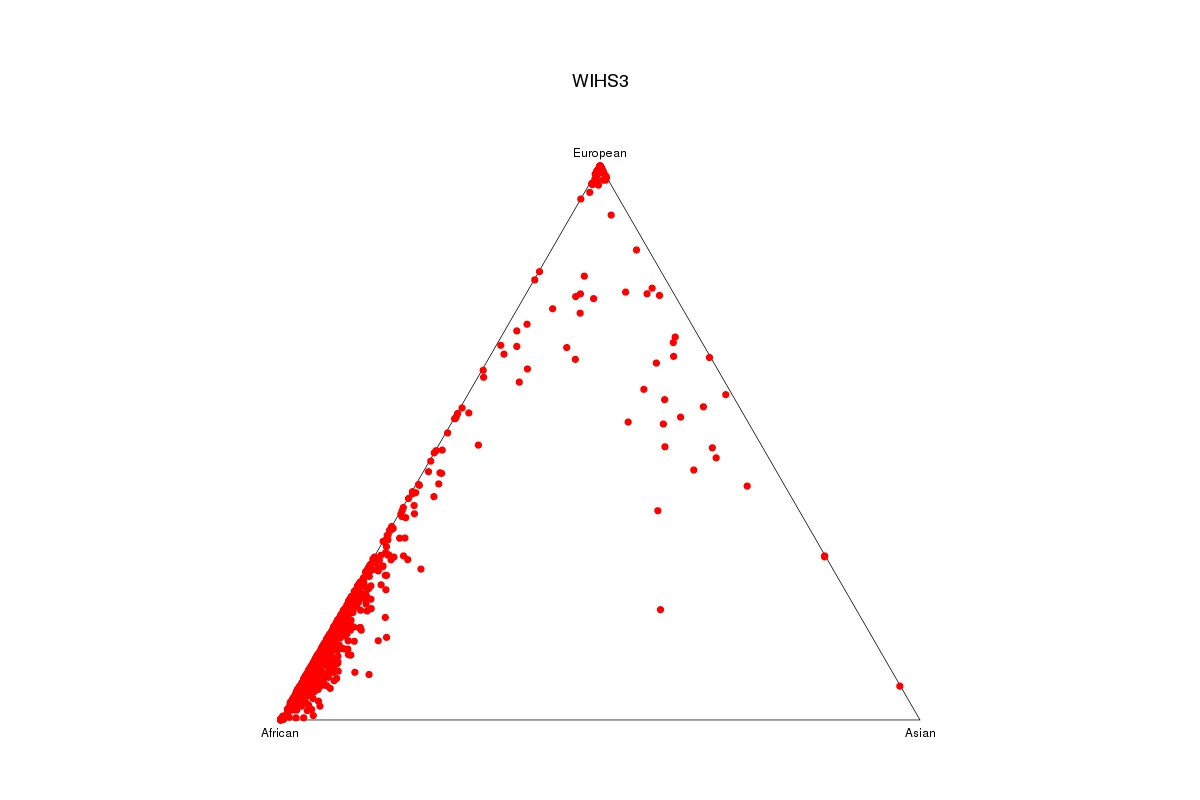

In [1]:
## R console ##
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/wihs3/qc/structure/002/afr_eas_eur_WIHS3.jpg", width=700, height=700)

#### Reassigning and removing outliers
The following retainment thresholds should be implemented:


| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 25%)$ \wedge $(EAS < 25%) |
| For AA retainment | (AFR > 25%)$ \wedge $(EAS < 25%) |
| For HA retainment | (AFR < 25%)$ \wedge $(EAS > 25%) |

Subject counts after applying the filters above.
```
wc -l $plots/*filtered
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/triangle_plots/filtered/aa_filtered
  110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/triangle_plots/filtered/ea_filtered
   21 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/triangle_plots/filtered/ha_filtered
```

Note that one subject was not assigned to any ancestry group:

```
num     ID.y    pop     cluster1        cluster2        cluster3
2150    3957_216359     WIHS3   0.306   0.495   0.199
```

In [ ]:
## EC2 command line
### get details on which subjects are reassigned ###

plots=$procD/structure/triangle_plots/filtered
ln -s $procD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 $procD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=vidus, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/aa_filtered >>\
    $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ea_filtered >>\
    $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    > $plots/ha_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ha_filtered >>\
    $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------


# subjects not assigned to any ancestry group
comm -23 <(cut -f1 $procD/structure/triangle_plots/afr_eas_eur.triangle_input | sort) \
    <(cut -f1 $procD/structure/triangle_plots/filtered/afr_eas_eur_filtered.triangle_input | sort) >\
    $plots/tmp

awk 'FNR==NR{map[$1] = $0; next} FNR==1{print map["num"]}
    {print map[$1]}' $procD/structure/triangle_plots/afr_eas_eur_for_filtering.txt $plots/tmp \
    > $plots/filtered_full_id.txt

In [ ]:
# Generate filtered triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/afr_eas_eur_filtered.triangle_input \
    --prefix $plots/afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $procD/structure/triangle_plots/afr_eas_eur_id_xref

#### Filtered results

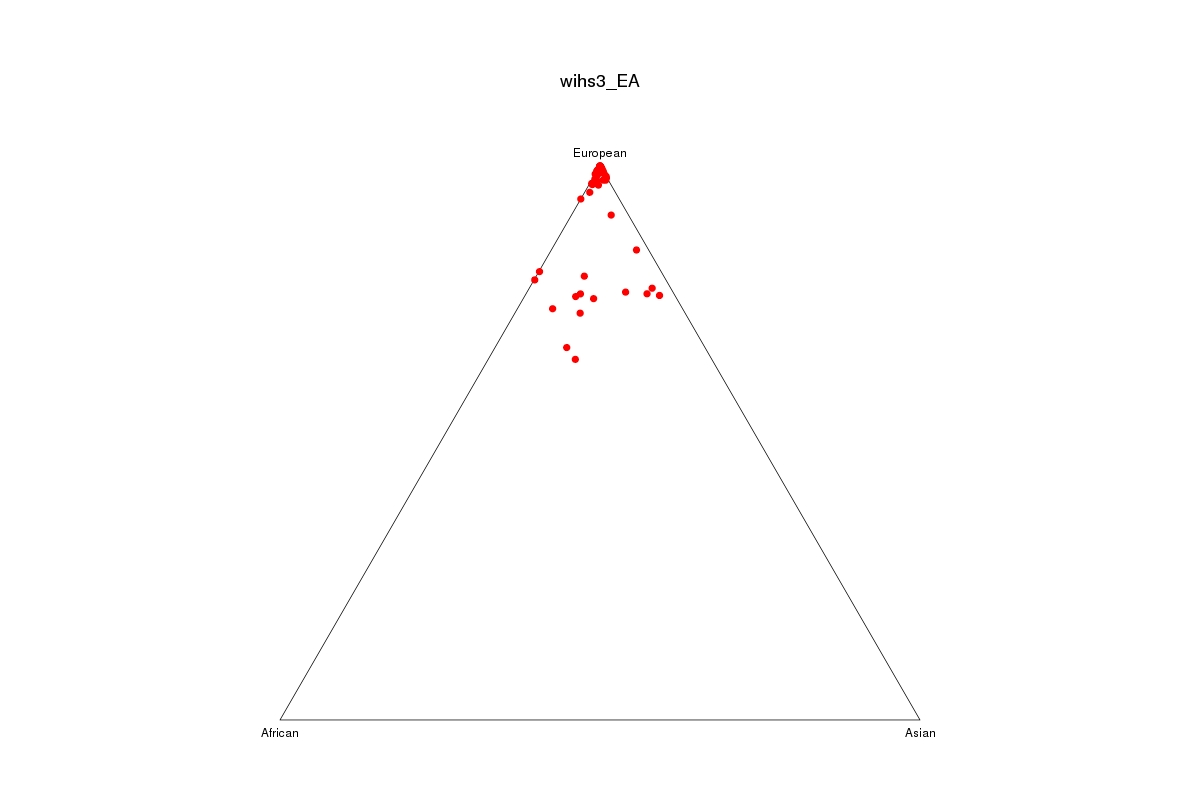

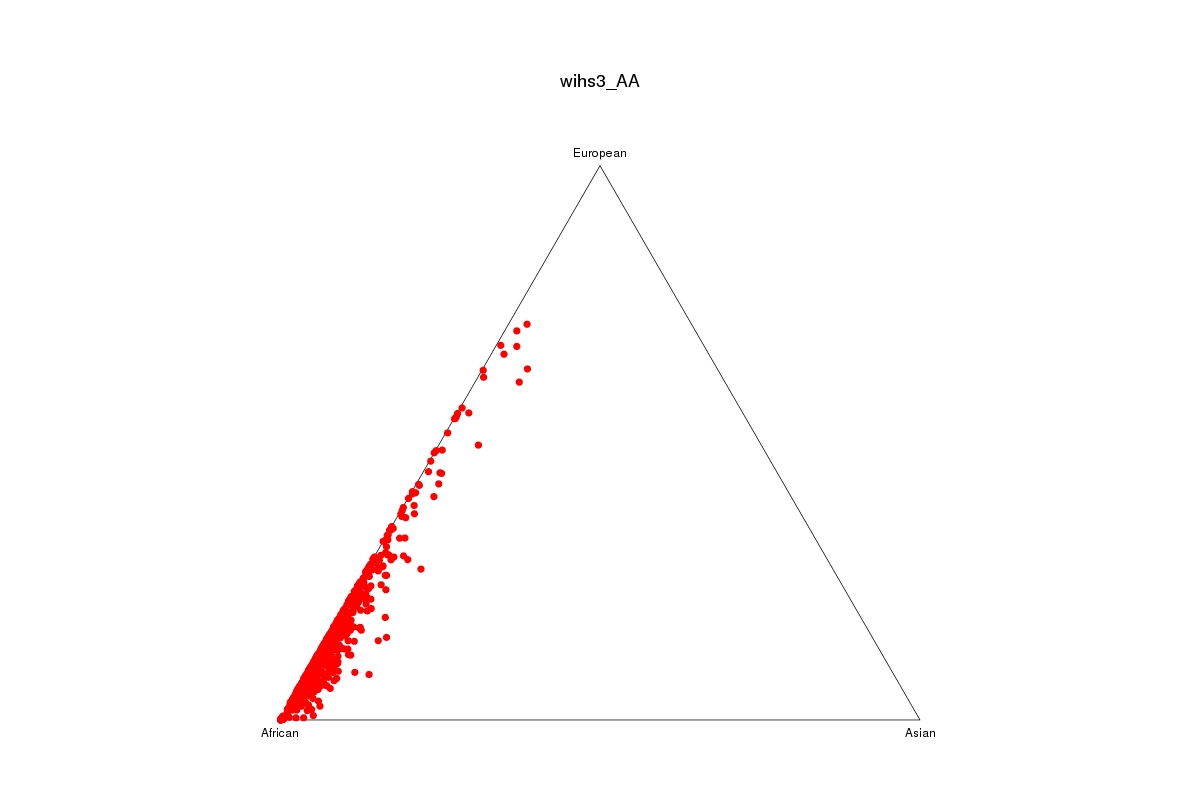

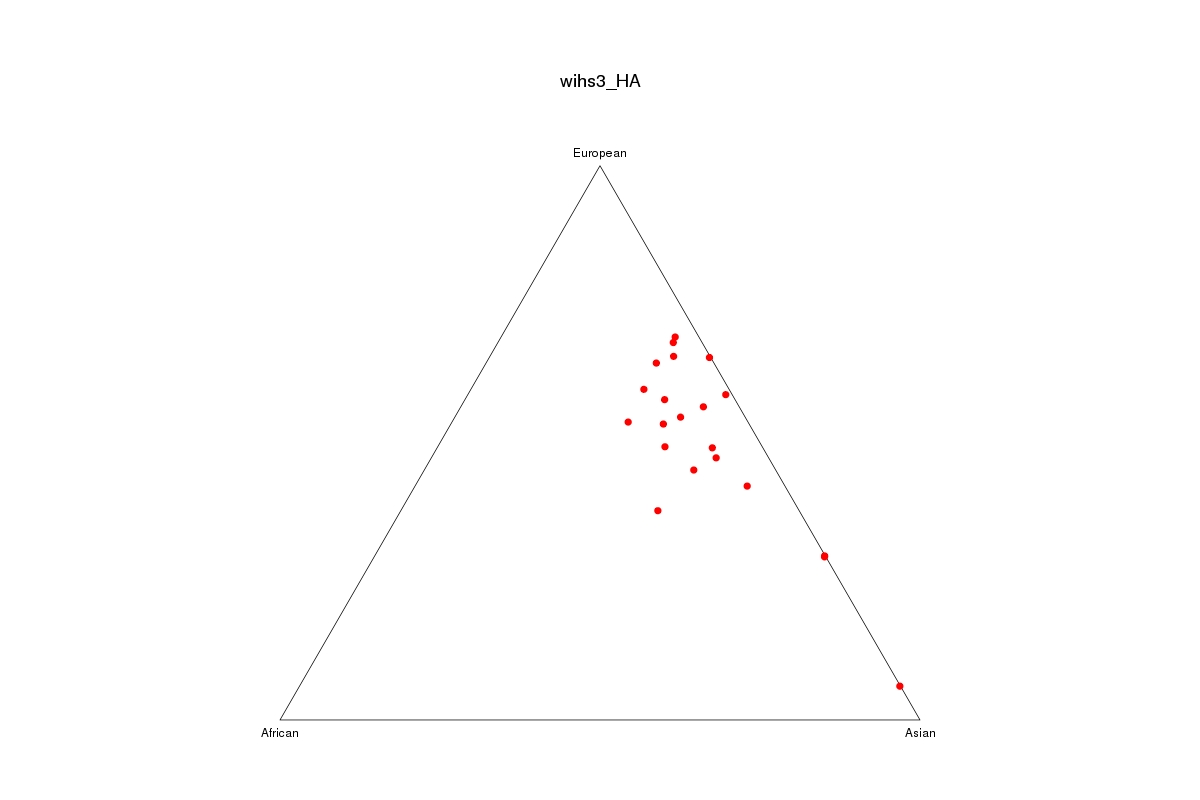

In [2]:
## R console ##
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV//wihs3/qc/structure//002//afr_eas_eur_filtered_wihs3_EA.jpg", width=800, height=800)
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV//wihs3/qc/structure//002//afr_eas_eur_filtered_wihs3_AA.jpg", width=800, height=800)
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV//wihs3/qc/structure//002//afr_eas_eur_filtered_wihs3_HA.jpg", width=800, height=800)

Because there are only 21 HA subjects subjects left after applying the ancestral thresholds for filtering, we will proceed with only the EAs and AAs.

## Post-Structure
### Create updated PLINK filesets

In [ ]:
## EC2 command line
anlist="aa ea"


# create directory structure
for ancestry in $anlist;do
    mkdir -p $procD/post_structure/$ancestry/{autosomes,chrx}
done

# get ancestry counts after filtering + create a keepIDs list
for an in $anlist;do
    awk -v an="${an^^}" -v study="$study" '$3==study"_"an {print $2}' \
        $plots/afr_eas_eur_filtered_for_filtering.txt > \
        $procD/post_structure/$an/subject_ids_keep.txt
    wc -l $procD/post_structure/$an/subject_ids_keep.txt
done

```
732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/subject_ids_keep.txt
110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/subject_ids_keep.txt
```

In [ ]:
# split famID_IID up by tab --> famID"\t"IID
for an in $anlist;do
    awk -F"_" '{print $1, $2}' $procD/post_structure/$an/subject_ids_keep.txt >\
        $procD/post_structure/$an/subject_ids_keep_formatted.txt
done

for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    docker run -v "$procD/:/data/" rticode/plink:1.9 plink \
        --memory 5000 \
        --bfile /data/prestructure/gw/$study \
        --keep /data/post_structure/$ancestry/subject_ids_keep_formatted.txt \
        --make-bed \
        --out /data/post_structure/$ancestry/${study}_structure
done

for an in $anlist; do
    wc -l $procD/post_structure/$an/*{bim,fam}
done            

```
  565580 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.bim
     732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.fam
     
  565580 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.bim
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.fam
```

In [ ]:
# Create autosome and chrx file sets
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"

    # Autosomes
    docker run -v "$procD/post_structure/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${ancestry}/${study}_structure \
        --autosome \
        --make-bed \
        --out /data/${ancestry}/autosomes/${study}_structure

    # Chrx (include split PARs)
    docker run -v "$procD/post_structure/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${ancestry}/${study}_structure \
        --chr 23,25 \
        --make-bed \
        --out /data/${ancestry}/chrx/${study}_unmerged

    # Combine split chrx and PARs
    docker run -v "$procD/post_structure/$ancestry/chrx:/data/" rticode/plink:1.9 plink \
        --noweb \
        --memory 5000 \
        --bfile /data/${study}_unmerged \
        --merge-x \
        --make-bed \
        --out /data/${study}_structure
done

## get counts
for an in $anlist;do
    wc -l $procD/post_structure/$an/{chrx,autosomes}/*structure.bim
done

```
   13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_structure.bim
  551742 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure.bim
  
   13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_structure.bim
  551742 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure.bim
```

### Autosome Processing
#### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate >3%.

In [ ]:
## Genotype call rate variant filter ##
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure \
        --geno $gcr \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_filter
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/${study}_structure_variant_gcr_filter.bim
    echo ""
done

```
537341 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_filter.bim

539250 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_filter.bim
```

#### Hardy-Weinberg equilibrium filtering
Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK --hardy, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [ ]:
## Calculate HW p-values for each ancestry group ##
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_filter \
        --hwe $hwe \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_filter
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/${study}_structure_variant_gcr_hwe_filter*{bim,fam}
    echo ""
done

```
  535286 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_hwe_filter.bim
     732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_hwe_filter.fam

  539073 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_hwe_filter.bim
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_hwe_filter.fam
```

#### Genotype call rate subject filter
**Note**: The genotype call rate subject filtering and the subsequent LD pruning are specifically for relatedness filtering calculations. Autosomes and chrX merging will be done using the PLINK file sets generated in the preceding step (HWE filtering).

I calculate the genotype missing call rate and remove any subjects with a rate > $3\%$.

In [ ]:
## Genotype call rate subject filter ##
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_filter \
        --mind $gcr \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_subject_gcr_filter
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/${study}_structure_variant_gcr_hwe_subject_gcr_filter.{fam,irem,bim}
    echo ""
done

```
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.fam
       3 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.irem
  535286 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.bim

     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.fam
wc: /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.irem: No such file or directory
  539073 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.bim
```

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of identity-by-state (IBS) and identity-by-descent (IBD) calculations. Consequently, the LD pruned data will be used as input into IBS and IBD calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## LD pruning 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/post_structure/${ancestry}/autosomes/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --priority 0 \
            --nslots 1 \
            --program  docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
                --bfile /data/${study}_structure_variant_gcr_hwe_subject_gcr_filter \
                --indep-pairwise 50 5 0.5 \
                --chr $chr \
                --out /data/${study}_genotypes_for_relatedness_filtering_ld_prune_chr${chr}
    done
done

In [ ]:
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    # Merge *prune.in files
    cat $procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_filtering_ld_prune_chr*.prune.in \
      > $procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_filtering_ld_prune_autosomes.prune.in

    # Create new PLINK filesets with only lD pruned variants
    docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_subject_gcr_filter \
        --extract /data/${study}_genotypes_for_relatedness_filtering_ld_prune_autosomes.prune.in \
        --make-bed \
        --out /data/${study}_genotypes_for_relatedness_ld_prune_filter
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter.{bim,fam}
    echo ""
done

```
  359674 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.bim
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.fam

 253143 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.bim
    110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.fam
```

#### Identical-by-state and identical-by-descent filtering
Identical-by-state or identity-by-state (IBS) filtering provides a means to identify duplicate subjects or monozygotic twins. Identical-by-descent or identity-by-descent allows for detection of high relatedness. For computational efficiency and memory usage limitations, ibd_pipeline.v4.sh is used to perform IBS/IBD calculations on data chunks that are used as input for IBS and IBD filtering. If the study contains AA subjects, then for AA subjects only, [KING](http://people.virginia.edu/~wc9c/KING/manual.html) is used as an additional relationship inference tool for filtering.

For these filtering steps, a list of individuals is identified separately for each filtering type then combined into a final list for exclusion. Following IBS filtering, if any individuals are identified for removal, a graph analysis needs to be done to account for an individual being related/identical to multiple individuals. Removal criteria is based on genotype calling rate. These individuals would need to be removed before running IBD filtering and KING. Graph analysis would need to be run after IBD calculations/KING if individuals were selected for removal.

In [ ]:
## Identical-by-state filtering ##

# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/post_structure/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter \
        --out_dir $procD/post_structure/$ancestry/autosomes/
    sleep 5s
done

In [ ]:
# Aggregate data 
for ancestry in $anlist; do
    outfile=$procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter.genome
    head -1 `ls $procD/post_structure/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/post_structure/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/post_structure/${ancestry}/autosomes/data.sub.*
    rm $procD/post_structure/${ancestry}/autosomes/tmp_sh*.sh
done

#### IBS filtering
For individual pairs with greater than 0.9 IBS score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBD list for final filtering but removed from the LD pruned data before running IBD filtering.

In [ ]:
# Calculate missingness
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/autosomes/:/data/" rticode/plink:1.9 plink \
        --noweb \
        --bfile  /data/${study}_structure_variant_gcr_hwe_subject_gcr_filter \
        --missing \
        --out /data/autosome_missing_call_rate
done

# Get list of individuals with IBS > 0.9
## note that I  changed it to underscore after study
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/post_structure/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter.genome \
        --imiss $procD/post_structure/$ancestry/autosomes/autosome_missing_call_rate.imiss \
        --type IBS \
        --out $procD/post_structure/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

**No subjects identified for removal** for either ancestry group, therefore graph analysis is not required.

```
================ aa ================

[1] "Reading genome file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ ea ================

[1] "Reading genome file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
```

#### Graph Analysis for IBS
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

**Note:** For this case, since no individuals were flagged as problematic, we can skip the IBS graph analysis.

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)

study <- "wihs3"
setwd("/shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure")
for(ancestry in c("ea", "aa")){
    stats = read.table(paste0(ancestry, "/autosomes/", study, "_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/", study, "_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Remove IBS problematic subjects
Before proceeding with IBD filtering, the problematic IBS subjects need to be removed.

In [ ]:
for ancestry in $anlist;do
    ibs_remove=$procD/post_structure/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
    if [ -f ${ibs_remove} ]; then
        ## Make new PLINK file set
        echo -e "\n\n================ ${ancestry} ================\n\n"
        docker run -v "$procD/post_structure/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter \
            --remove /data/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove \
            --make-bed \
            --out /data/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter

        num_removed=$(wc -l ${ibs_remove} | awk '{print $1}')
        echo -e "\n\n${num_removed} $ancestry IBS subjects removed."
    else
        ## go ahead and make updated plink filesets to keep the naming convention
        echo -e "\n\n================ ${ancestry} ================\n\n"
        docker run -v "$procD/post_structure/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_filter \
            --make-bed \
            --out /data/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
        echo -e "\n\nNo $ancestry IBS subjects to removed.\n\n"
    fi

    sleep 5
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
    echo 
done

```
No aa IBS subjects to removed.
No ea IBS subjects to removed.

729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam

110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
```

In [ ]:
# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter \
        --out_dir $procD/post_structure/${ancestry}/autosomes
    sleep 5s
done

In [ ]:
# Aggregate data
for ancestry in $anlist; do
    outfile=$procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome
    head -1 `ls $procD/post_structure/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/post_structure/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/post_structure/${ancestry}/autosomes/data.sub.*
    rm $procD/post_structure/${ancestry}/autosomes/tmp_sh*.sh
done

#### IBD filtering
For individual pairs with greater than 0.4 IBD score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBS list.

In [ ]:
## EC2 command line

# Get list of individuals with IBD > 0.4
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/post_structure/$ancestry/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome \
        --imiss $procD/post_structure/$ancestry/autosomes/autosome_missing_call_rate.imiss \
        --type IBD \
        --pi_hat_threshold 0.4 \
        --out $procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
done

```
================ aa ================

[1] "Reading genome file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ ea ================

[1] "Reading genome file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
```

#### KING - relationship inference for AAs
For subjects with African ancestry, KING probides a better estimation of relatedness. I use this software to further identify subjects for removal.

In [ ]:
/shared/bioinformatics/software/third_party/king_v2.1.2/king \
    -b $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.bed \
    --kinship \
    --prefix $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king

# Extract PLINK IBD calculations for subject pairs
outFile=$procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness.genome_lite
echo -e "PAIR_ID\tPI_HAT" > $outFile
tail -n +2 $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome | \
    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[9];' >> $outFile

# Extract KING kinship calculations for subject pairs
outFile=$procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite
echo -e "PAIR_ID\tKINSHIP" > $outFile
tail -n +2 $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin0 | \
    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[7];' >> $outFile

tail -n +2 $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \
    perl -lane '$pairId = "";
        if ($F[1] < $F[2]) {
            $pairId = join("_",$F[0],$F[1],$F[0],$F[2]);
        } else {
            $pairId = join("_",$F[0],$F[2],$F[0],$F[1]);
        }
        print $pairId."\t".$F[8];' >> $outFile


# Combine IBD and kinship results
Rscript /shared/bioinformatics/software/R/merge_datasets.R \
    --in_1 $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness.genome_lite \
    --in_1_column PAIR_ID \
    --in_1_header \
    --in_2 $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite \
    --in_2_column PAIR_ID \
    --in_2_header \
    --out $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome_king \
    --out_header

# Identify discrepancies between PLINK IBD and KING kinship values
perl -lane 'if ($F[2] > 0.177 && $F[1] > 0.4) { print "AGREE\t".$_; } elsif ($F[2] > 0.177 || $F[1] > 0.4) { print "DISAGREE\t".$_; }' $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome_king \
    > $procD/post_structure/aa/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter_genome_king.ibd_comparison

#### Graph Analysis for IBD
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

<br>

**Note:** For this case, since no individuals were flagged as problematic, we can skip the IBD graph analysis.

In [ ]:
## EC2 command line

# Get genotype missing call rate for graph analysis
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
        docker run -v "$procD/post_structure/$ancestry/autosomes:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_subject_gcr_filter \
        --missing \
        --out /data/${study}_genotypes_for_relatedness
done

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
study <- "wihs3"
setwd("/shared/jmarks/hiv/wihs3/genotype/observed/processing/002/structure/output_files")
for(ancestry in c("ea","aa")){
    stats = read.table(paste0(ancestry, "/autosomes/", study, "_genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/", study, ".genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Constructing relatedness filtering lists
The output of the IBS filtering and the IBD filtering are combined into a single remove list.

**Note:** There were no problematic IBS nor IBD individuals flagged.

In [ ]:
# Get list of individuals from IBD and IBS filter lists

# create empty dummy files if they do not exist
function exists_file {
    if [ ! -f $1 ]; then
    echo -e "Creating an empty file:\n$1\n"
    touch $1
    fi
}

for ancestry in $anlist; do
    ibd_file=$procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove
    ibs_file=$procD/post_structure/${ancestry}/autosomes/${study}_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
    combined_file=$procD/post_structure/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove

    exists_file $ibd_file
    exists_file $ibs_file

    cat $ibd_file $ibs_file | sort -u > $combined_file
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/autosomes/*remove
done


The list of subjects in this `*remove` file will be retained as a filtering list for the merged autosome and chrX PLINK file sets. This list includes subjects that were indicated for removal by both `ibs` and `ibd` filtering steps.

```
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove

0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/autosomes/wihs3_genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
```

### ChrX Processing 
#### Missing data subject filtering
We calculate the proportion of missing genotype calls on chrX using PLINK to assess whether any subjects have data missing for the whole chromosome.

In [ ]:
# Get missing call rate for chrx
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/chrx:/data/" rticode/plink:1.9 plink \
        --noweb \
        --memory 3000 \
        --bfile /data/${study}_structure \
        --missing \
        --chr 23 \
        --out /data/chrx_missing_call_rate

    # Find subjects that have data missing for whole chrx
    tail -n +2 $procD/post_structure/${ancestry}/chrx/chrx_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> \
        $procD/post_structure/${ancestry}/chrx/missing_whole_chrx.remove
    echo -e "\n\nNumber of ${ancestry} subjects with missing whole chromosome: $(wc -l $procD/post_structure/${ancestry}/chrx/missing_whole_chrx.remove)\n\n"
done

**Note:** If subjects ever show up as having missing data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosome.

```
Number of aa subjects with missing whole chromosome: 0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/missing_whole_chrx.remove

Number of ea subjects with missing whole chromosome: 0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/missing_whole_chrx.remove
```

In [ ]:
# clean up chrx directory
for an in $anlist;do
    rm -f $procD/post_structure/$an/chrx/chr*missing_call_rate*
done

#### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate $> 3\%$.

In [ ]:
## Genotype call rate variant filter
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/chrx:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure \
        --geno $gcr \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_filter
done

for ancestry in $anlist; do
    wc -l $procD/post_structure/$ancestry/chrx/*bim
done

```
  13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_structure.bim
  13481 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_structure_variant_gcr_filter.bim
  13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_unmerged.bim
  
  13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_structure.bim
  13527 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_structure_variant_gcr_filter.bim
  13838 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_unmerged.bim
```

#### Hardy-Weinberg equilibrium filtering (for females)
The Hardy-Weinberg Theorem (or Law) characterizes the distributions of genotype frequencies. It is basically the null model for population genetics. Tests for Hardy-Weinberg genotype frequencies are used primarily to test for population stratification and other forms of non-random mating. Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK `--hardy`, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

See [nature webpage](https://www.nature.com/scitable/knowledge/library/the-hardy-weinberg-principle-13235724) which describes more about HWE.

**Note**: [HWE is typically applied to only females](https://www.ncbi.nlm.nih.gov/pubmed/27071844), therefore that is the approach we will take.

```
Sex code ('1' = male, '2' = female, '0' = unknown)
```

**Note2**: For this case, all of the subjects are female.

In [ ]:
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/chrx/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_filter \
        --hwe $hwe \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_filter
done

for an in $anlist;do
    wc -l $procD/post_structure/$an/chrx/${study}_structure_*bim
    echo ""
done

```
 13481 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_structure_variant_gcr_filter.bim
 13434 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/chrx/wihs3_structure_variant_gcr_hwe_filter.bim

 13527 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_structure_variant_gcr_filter.bim
 13526 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/chrx/wihs3_structure_variant_gcr_hwe_filter.bim
```

In [ ]:
### legacy code, might come in handy someday ###


## update PLINK file set
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --bed ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bed \
#    --bim ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bim \
#    --fam ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.mapped.fam \
#    --make-bed \
#    --out $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter
#
## create a fam file of only females
#awk '{ if($5==2) {print $1,$2}}' $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.fam >\
#    $procD/ea/chrX/females_ids
#
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --memory 3800 \
#    --noweb \
#    --bfile $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter \
#    --keep $procD/ea/chrX/females_ids \
#    --make-bed \
#    --out $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females
#
#wc -l $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females.fam
#"""
#236 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females.fam
#"""
#
## Calculate HW p-values for the females for each ancestry group
#for ancestry in $anlist; do
#    echo -e "\n\n================ ${ancestry} ================\n\n"
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --memory 3800 \
#        --noweb \
#        --bfile $procD/$ancestry/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females \
#        --hwe $hwe \
#        --make-bed \
#        --out $procD/${ancestry}/chrX/hwe.filtered
#done
#
#wc -l /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.{bim,fam}
#"""
# 16877 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.bim
#   236 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.fam
#"""
#
#cut -f2 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.bim  >\
#    $procD/ea/chrX/hwe.filtered.keep
#
## now extract those SNPs from combined (male & female) data set
#for ancestry in $anlist; do
#    echo -e "\n\n================ ${ancestry} ================\n\n"
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --memory 3800 \
#        --noweb \
#        --bfile $procD/$ancestry/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter \
#        --extract $procD/ea/chrX/hwe.filtered.keep \
#        --make-bed \
#        --out $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter
#done
#
#wc -l $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.*
#""" 
#    1849 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.bed
#   16877 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.bim
#     972 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.fam
#"""


### Merge autosomes and chrX
The data processed through to HWE filtering for both the autosomes and chrX are merged before applying the final subject filtering steps.

In [ ]:
## Merge autosomes and chrX
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --noweb \
        --bfile /data/autosomes/${study}_structure_variant_gcr_hwe_filter \
        --bmerge /data/chrx/${study}_structure_variant_gcr_hwe_filter \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_filter
done

for ancestry in $anlist; do
    wc -l $procD/post_structure/$ancestry/*.{bim,fam}
done

```
  565580 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.bim
  548720 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_filter.bim
  548720 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.bim
     732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.fam
     732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_filter.fam
     732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.fam
     
  565580 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.bim
  552599 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_filter.bim
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.fam
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_filter.fam
```

#### Relatedness filter
IBS & IBD filters <br>
From relatedness calculations on the autosomal data, I remove subjects that are closely related or seemingly identical.

In [ ]:
## Relatedness filter
# Remove subjects 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_filter \
        --remove /data/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_ibs_ibd_filter
    #echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove)\n\n"
done

for ancestry in $anlist;do
    wc -l $procD/post_structure/${ancestry}/${study}_structure*fam
done

```
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_filter.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_ibs_ibd_filter.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.fam
  
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.fam
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_filter.fam
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_ibs_ibd_filter.fam
```

#### Genotype call rate subject filter
I calculate the genotype missing call rate and remove any subjects with a rate $> 3\%$.

In [ ]:
## Genotype call rate subject filter 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --noweb \
        --bfile /data/${study}_structure_variant_gcr_hwe_ibs_ibd_filter \
        --mind $gcr \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter
done

for ancestry in $anlist; do
    wc -l $procD/post_structure/$ancestry/${study}_structure*.fam
done

```
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_filter.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_ibs_ibd_filter.fam
  729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter.fam
  732 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/wihs3_structure_variant_gcr_hwe_subject_gcr_filter.fam
  
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure.fam
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_filter.fam
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_ibs_ibd_filter.fam
 110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter.fam
```

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of sex check and excessive homozygosity calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## LD prune (for sex check and excessive homozygosity filters)
for ancestry in $anlist; do
    mkdir -p $procD/post_structure/${ancestry}/ld_prune
    for chr in {1..23}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/post_structure/ld_prune/${ancestry}/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --nslots 1 \
            --priority 0 \
            --program  docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
                --bfile /data/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out /data/ld_prune/${study}_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_prune_chr$chr
    done
done

In [ ]:
# Merge *prune.in files
for ancestry in $anlist; do
    cat $procD/post_structure/${ancestry}/ld_prune/${study}_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_prune_chr*.in \
        > $procD/post_structure/${ancestry}/ld_prune/ld_pruned_snps

    # Create new PLINK filesets with only lD pruned variants
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter \
        --extract /data/ld_prune/ld_pruned_snps \
        --make-bed \
        --out /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all
done

for ancestry in $anlist; do
    echo
    wc -l $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.{fam,bim}
    echo
done

```
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.fam
  369772 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.bim

    110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.fam
 260570 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.bim
```

#### Sex Check
To verify that self-reported gender status matches with the genetic information, I use PLINK `--split-x` followed by `--check-sex` to confirm the data agree. Our discrepancy criteria are

* Reported as male (coded as 1) but F < 0.2
* Reported as female (coded as 2) but F > 0.8

In [ ]:
# Break out the pseudo-autosomal region on chrX (will be stored as chr 25)
for ancestry in $anlist; do
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all \
        --split-x b37 \
        --make-bed \
        --out /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx

    # Run sex check
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx \
        --check-sex \
        --out /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx

    # Get subjects that do not meet inbreeding coefficient thresholds
    perl -lane 'if ($F[2]==1 && $F[5]<0.2) { print $_; } elsif ($F[2]==2 && $F[5]>0.8) { print $F[0]."\t".$F[1]; }' \
        $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck \
        > $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.threshold_fail

    # Get subjects that are problematic due to no inbreeding coefficient value
    perl -lane 'if ($F[4] eq "PROBLEM" && $F[5] eq "nan") { print $F[0]."\t".$F[1]; }' \
        $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck \
        > $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.nan_fail

    # Combine discordant subjects into one remove list
    cat $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.*_fail | \
        sort -u \
        > $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.remove
done

# Print number of discrepancies
for ancestry in $anlist; do
    wc -l $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.remove
    echo
done

For these data the sex check yielded **0 discrepancies** for the EA subjects under our criteria. If any individuals failed the check then they would be removed before subsequent steps using the file set generated after gentoype call rate subject filtering (before removing the pseudo-autosomal chrX region).

```
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.remove

0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_split_chrx.sexcheck.remove
```

#### Excessive homozygosity filter
Excessive homozygosity checks for inbreeding and population substructure. This check is implemented using PLINK. According to their documentation, the statistics used for this filtering are not LD-sensitive, i.e., an LD pruned dataset is recommended as input. Additionally, the documentation states that only autosomal data are used, so concerns of chrX biasing results are irrelevant.

In [ ]:
# Get homozygosity stats
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all \
        --het \
        --out /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all

   # Identify problematic subjects
    perl -lane 'if ($F[5] < -0.2 || $F[5] > 0.5) { print $F[0]." ".$F[1]; }'\
        $procD/post_structure/$ancestry/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all.het \
    > $procD/post_structure/$ancestry/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_homo.remove

    # Remove problematic subjects
    docker run -v "$procD/post_structure/$ancestry/:/data/" rticode/plink:1.9 plink \
        --bfile /data/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter \
        --remove /data/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_homo.remove \
        --make-bed \
        --out /data/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_homozyg_filter

    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  $procD/post_structure/${ancestry}/ld_prune/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_homo.remove)\n\n"
done

for an in $anlist; do
    echo
    wc -l $procD/post_structure/$an/ld_prune/*homo.remove
    echo
done

No subjects to remove, in this case. 

```
0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/aa/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_homo.remove

0 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/ea/ld_prune/wihs3_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_filter_ld_pruned_chr_all_homo.remove
```

### Recoding variants for 1000G phase 3
RefSeq IDs (rsIDs) for variants can vary depending on the dbSNP build used and variant IDs do not all use RefSeq nomenclature. To provide a common nomenclature that will make comparisons across data sets feasible, I use a script that recodes all variant names to match 1000G phase 3 variants by position and alleles. The 1000G Phase 3 data I used for STRUCTURE are from /shared/data/ref_panels/1000G/2013.05/plink on AWS EC2, but /shared/data/ref_panels/1000G/2014.10/ also contains 1000G Phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the IMPUTE2 website and reformatted to be directly compatible with IMPUTE2.

The data in `/shared/data/ref_panels/1000G/2014.10/` is used for variant name recoding, but the 1000G genotype information is acquired from `/shared/data/ref_panels/1000G/2013.05/plink`.

In [ ]:
for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp  $procD/post_structure/$ancestry/${study}_structure_variant_gcr_hwe_ibs_ibd_subject_gcr_homozyg_filter.${ext} \
            $procD/post_structure/1000g_name_recoding/${ancestry}_chr_all.${ext}
    done
done

wc -l $procD/post_structure/1000g_name_recoding/*{bim,fam}

```
  548720 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all.bim
  552599 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all.bim
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all.fam
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all.fam
```

#### Variant ID updating
Because the 1000G data and the study data have RefSeq IDs (rsIDs) from different dbSNP builds, I standardize them using convert_to_1000g_ids.pl. In the study data set, certain indels may be represented as two variants, a monomorphic variant and an indel with the - symbol for one of the alleles. For example:

```
1   rs201826967  0.809   57873968   0   G
1   rs11284630   0.809   57873969   -   A
```

These two variants represent a G:GA indel and is coded as such in the 1000 Genomes data. The script to update the names to 1000 Genomes IMPUTE2 format will assign the same ID to these two variants, so that the indel above will be coded as:

```
1       rs11284630:57873968:GA:G        0.809   57873968        0       G
1       rs11284630:57873968:GA:G        0.809   57873969        -       A
```

The duplicated IDs will cause problems for PLINK filtering, so I will remove the variant from a set of duplicate IDs that has the lower genotype call rate. Duplicates may arise for other reasons, and they will be filtered based on the same criterion.

In [ ]:
#thouN=$procD/post_structure/1000g_name_recoding

# Break out data by chr
for ancestry in $anlist; do
    for chr in {1..23}; do
    docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
            --noweb \
            --memory 2048 \
            --bfile /data/${ancestry}_chr_all \
            --chr ${chr} \
            --make-bed \
            --out /data/${ancestry}_chr${chr}
    done
done

In [ ]:
# Rename study autosome variant IDs
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode_to_1000g_${chr} \
            --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $thouN/${ancestry}_chr${chr}.bim \
                --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done

# Rename study chrX variant IDs
chr=23
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $thouN/${ancestry}_chr${chr}.bim \
            --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done

# Rename 1000G autosome variant IDs
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
            --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done

# Rename 1000G chrX variant IDs
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name recode_to_1000g_${chr} \
    --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
    --mem 8 \
    --priority 0 \
    --nslots 1 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bim \
        --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}


#### Remove duplicate variant ID
Many of the functions in PLINK will throw errors when duplicate variant IDs are found.To resolve this, duplicate variant IDs are identified, and only the duplicate variant with the best genotype call rate is retained.

In [ ]:
for ancestry in $anlist; do
    for chr in {1..23}; do
        echo -e "\n ==== ${ancestry} - chr${chr} ==== \n"
        # Append _X (where X is a number) to the end of the variant IDs for all but 1st occurrence of duplicates
        perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    }' $thouN/${ancestry}_chr${chr}_renamed.bim > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.bim

        # Generate list of duplicate SNPs
        grep -P "_[1-9]" $thouN/${ancestry}_chr${chr}_renamed_dups.bim |
            perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list
    done
done

# Check if any duplicates were found
for an in $anlist;do
    wc -l $thouN/${an}*.dupvar_list
done

There were duplicate SNPs cause be indel recoding. We will therefore proceed to the next section to remove the SNP with the lower gcr.

In [ ]:
for ancestry in $anlist; do
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        ## Get call rates for duplicate SNPs
        docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
            --bed /data/${ancestry}_chr${chr}.bed \
            --bim /data/${ancestry}_chr${chr}_renamed_dups.bim \
            --fam /data/${ancestry}_chr${chr}.fam \
            --extract /data/${ancestry}_chr${chr}_renamed_dups.dupvar_list \
            --missing \
            --out /data/${ancestry}_chr${chr}_renamed_dups

        # Create remove list that contains the duplicate with the higher missing rate
        tail -n +2 $thouN/${ancestry}_chr${chr}_renamed_dups.lmiss | \
            perl -lane 'BEGIN { %missingness = (); }
                        if ($F[1] =~ /^(\S+)\_/) {
                            $duplicateName = $1
                        } else {
                            $duplicateName = $F[1]."_2";
                        }
                        if (exists($missingness{$duplicateName})) {
                            if ($missingness{$duplicateName} > $F[4]) {
                                print $duplicateName;
                            } else {
                                print $F[1];
                            }
                        } else {
                            $missingness{$F[1]} = $F[4];
                        }' \
                > $thouN/${ancestry}_chr${chr}_renamed_dups.remove

        docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
            --bed /data/${ancestry}_chr${chr}.bed \
            --bim /data/${ancestry}_chr${chr}_renamed_dups.bim \
            --fam /data/${ancestry}_chr${chr}.fam \
            --exclude /data/${ancestry}_chr${chr}_renamed_dups.remove \
            --make-bed \
            --out /data/${ancestry}_chr${chr}_renamed_dups_removed

        # Remove appendages (i.e. _2) from any variant IDs 
        perl -i.bak -lne 's/\_2//; print;' $thouN/${ancestry}_chr${chr}_renamed_dups_removed.bim
    done
done

### Merge chromosome data

In [ ]:
## Merge chromosome data

# Add chromosomes that had duplicates removed to the merge list
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/;  print $1;  }'); do
        baseName=/data/${ancestry}_chr${chr}_renamed_dups_removed
        echo ${baseName}.bed ${baseName}.bim ${baseName}.fam
    done > $thouN/${ancestry}_renamed.chr_merge

    # Add all other chromosomes to the merge list
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] == 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        baseName=/data/${ancestry}_chr${chr}
        echo ${baseName}.bed ${baseName}_renamed.bim ${baseName}.fam
    done >> $thouN/${ancestry}_renamed.chr_merge

    # Merge chromosomes
    docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
        --merge-list /data/${ancestry}_renamed.chr_merge \
        --make-bed \
        --out /data/${ancestry}_chr_all_renamed
done

for an in $anlist;do
    wc -l $thouN/${an}_chr_all_renamed.*{fam,bim}
done


```
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed.fam
  548710 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed.bim
  
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed.fam
  552589 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed.bim
```

### Allele discordance
As a way of standardizing the data, I use 1000G phase 3 data as a reference. The study data may not match the 1000G phase 3 data for several reasons including

* Discordant names
* Discordant positions
* Discordant alleles (swapped major and minor alleles)
* Polymorphic alleles not fixed by strand flipping
* Discordant allele frequencies

I perform checks for these discordances using the 1000G Phase 3 data derived from data/ref_panels/1000G/2014.10/ derived from the May 2013 release. These data were downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2. These data will be used for ID recoding and MAF calculations.

To determine if any study data variants have flipped alleles, I compare the variants to the appropriate 1000 Genomes Phase 3 reference superpopulation. For example, African ancestry is compared to AFR, European ancestry is compared to EUR, and Hispanic ancestry is compared to AMR.

Discordance checks are used mainly to

1. Determine allele frequency discordances to remove prior to imputation
2. Determine if alleles are properly coded in reference to the forward/positive genome strand

A large number of discordant variants indicates potential allele flipping/mismatching issues. If the number of discordant heterozygous variants is less than approximately 10,000, then it is unlikely that there were major issues with flipping or mismatching that indicate coding alleles to the wrong strand.

#### Preparing study data
The allele discordance scrip requires as input a file of MAFs, so I calculate this using PLINK.

In [ ]:
# Calculate allele frequencies
for ancestry in $anlist; do
    docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
        --bfile /data/${ancestry}_chr_all_renamed \
        --freq \
        --out /data/${ancestry}_chr_all_renamed
done

#### Preparing 1000G phase 3 data
MAF data are needed for 1000 Genomes data in addition to the study data, so I calculate these for the superpopulations(s) that matches the study group subject ancestries.

In [ ]:
# Get list of study variant IDs
for ancestry in $anlist; do
    perl -lane 'if ($F[0] <= 23) { print $F[1]; }' $thouN/${ancestry}_chr_all_renamed.bim | \
        sort > $thouN/${ancestry}_chr_all_sorted_variants.txt
done

In [ ]:
# Calculate autosome and chrX MAFs for 1000G EUR
for ancestry in $anlist;do
    if [ $ancestry == "ea" ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr} \
            --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
                --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
                --keep_groups ${pop}
    done

    chr=23
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_${chr} \
        --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
        --mem 7 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr ${chr} \
            --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
            --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
            --keep_groups ${pop}
done

In [ ]:
# Merge per chr MAFs for overlap
for ancestry in $anlist; do
    if [ $ancestry == ea ]; then
        pop="EUR"
    else
        pop="AFR"
    fi

    head -n 1 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr1.maf >\
        $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
    tail -q -n +2 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr{1..23}.maf >> \
        $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
done

#### Discordance check

In [ ]:
# Run discordance checks for each ancestry group
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

In [ ]:
# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
    echo
done

wc -l $thouN/*_chr_all_renamed.*{bim,fam}

```
discordant_positions    4409
discordant_names        23
discordant_alleles      30616
discordant_alleles_not_fixed_by_strand_flip     25513
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        1
at_cg_snps_freq_diff_gt_0.2     85

/shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    4466
discordant_names        23
discordant_alleles      30611
discordant_alleles_not_fixed_by_strand_flip     25506
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        1
at_cg_snps_freq_diff_gt_0.2     105
```

___


```
  548710 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed.bim
  552589 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed.bim
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed.fam
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed.fam
```

### Set heterozygous haploids to missing

In [ ]:
## Set heterozygous haploids to missing
for ancestry in $anlist; do
    docker run -v "$thouN:/data/" rticode/plink:1.9 plink \
    --noweb \
    --memory 4000 \
    --bfile /data/${ancestry}_chr_all_renamed \
    --set-hh-missing \
    --make-bed \
    --out /data/${ancestry}_chr_all_renamed_hh_missing
done


wc -l $thouN/*_chr_all_renamed_hh_missing.*{bim,fam}

```
  548710 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed_hh_missing.bim
  552589 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed_hh_missing.bim
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/aa_chr_all_renamed_hh_missing.fam
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/post_structure/1000g_name_recoding/ea_chr_all_renamed_hh_missing.fam
```

### Observed genotype finalization
As a starting point for haplotype phasing and imputation, I store the final QC processed PLINK binary fileset in a new directory final.

In [ ]:
## Observed genotype finalization
final=$procD/../../final/

# Copy file sets to final directory
for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp $thouN/${ancestry}_chr_all_renamed_hh_missing.${ext} $final/${study}_${ancestry}_chr_all.${ext}
    done
done

wc -l $final/*{bim,fam}

```
  548710 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/../../final//wihs3_aa_chr_all.bim
  552589 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/../../final//wihs3_ea_chr_all.bim
  
     729 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/../../final//wihs3_aa_chr_all.fam
     110 /shared/jmarks/hiv/wihs3/genotype/observed/processing/002/../../final//wihs3_ea_chr_all.fam
```

### Final upload to S3
Upload post-qc genotype files to AWS S3.

In [ ]:
# gzip final files 
for f in $final/*; do
    gzip $f
done

aws s3 sync $final s3://rti-hiv/wihs3/data/genotype/observed/final


# gzip processing files
gzip -r $procD &
aws s3 sync $procD s3://rti-hiv/wihs3/data/genotype/observed/processing/

# Pre-Imputation Processing
We will now prepare the genotype data for imputation on the [Michigan Imputation Server](https://imputationserver.sph.umich.edu/start.html).

## Create Directory Structure
The following section needs to be modified each time to reflect:
* where the genotype data (post-QC) are stored
* where the base directory for the pre-imputation data processing will be
* the study or studies involved
* the ancesty group(s) involved
* the data to be processed (all_chr or just chr23)

In [ ]:
# parameters 
base_dir=/shared/jmarks/hiv/wihs3/genotype/imputed/processing # DO NOT end in forward slash
ancestry_list="aa ea" # space delimited Ex. "ea aa ha"
study_list="wihs3" # space delimited 
#base_name="chr_all" # chr_all chr23 

# create directory structure
mkdir -p ${base_dir}/{intersect,1000g,impute_prep}
for study in ${study_list};do
    mkdir ${base_dir}/${study}/strand_check

    for ancestry in ${ancestry_list};do
        mkdir -p ${base_dir}/${study}/genotype/${ancestry}
        
    done
done


# create link to post-qc data
for an in $ancestry_list; do
    cd /shared/jmarks/hiv/wihs3/genotype/imputed/wihs3/genotype/$an
    for ext in {fam,bed,bim}; do
        cp /shared/jmarks/hiv/wihs3/genotype/observed/final/wihs3_${an}_chr_all.$ext \
            wihs3_${an}.$ext
    done
done

## GRCh37 strand and allele discordance check
### MAF for study data (all chromosomes)

In [ ]:
# Write out the MAF report
for study in ${study_list}; do
    for ancestry in ${ancestry_list}; do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/genotype/$ancestry/${study}_${ancestry} \
            --freq \
            --out /data/strand_check/${ancestry}
    done
done


# Get list of variants from all studies
studies=($study_list)  #studies=(uhs1 uhs2 uhs3_v1-2 uhs3_v1-3 uhs4) # array of study names
num=${#studies[@]}

## Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/${studies[$i]}/genotype/$ancestry/*bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry ${study_list}...\n"
    cat ${bim_files[@]}| cut -f2 | sort |  uniq -c | awk -v num=$num '$1 == num {print $2}' \
        > ${base_dir}/intersect/${ancestry}_variant_intersection.txt
    wc -l ${base_dir}/intersect/${ancestry}_variant_intersection.txt
done 

### MAF for 1000G
The current setup requires the 1000G MAF for autosomes and chrX to be processed separately. This pipeline is also currently set up to handle EUR and AFR populations. 
#### Autosomes
Get 1000G MAF for chromosomes 1&ndash;22 (autosomes).

In [ ]:
# Calculate autosome MAFs for 1000G populations
for ancestry in ${ancestry_list};do
    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_MAF \
            --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
                --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
                --keep_groups ${pop}
    done
done

#### chrX
Get 1000G MAF for chromosome 23 (chrX).

In [ ]:
chr=23
for ancestry in ${ancestry_list};do

    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_23_MAF \
        --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
        --mem 6.8 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr $chr \
            --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
            --keep_groups ${pop}
done

### Merge 1000G chromosomes

In [ ]:
# Merge per chr MAFs for each 1000G population
for ancestry in ${ancestry_list};do
    if [ $ancestry == "ea" ]
    then
        pop="EUR"
    elif [ $ancestry == "ha" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    head -n1 ${base_dir}/1000g/${pop}_chr1.maf > ${base_dir}/1000g/${pop}_chr_all.maf
    for chr in {1..23}; do
            tail -q -n +2 ${base_dir}/1000g/${pop}_chr${chr}.maf >> \
                ${base_dir}/1000g/${pop}_chr_all.maf
    done
done

###  Allele Discordances Check
The allele discordances will be resolved by
* Flipping allele discordances that are fixed by flipping
* Removing SNPs with discordant names
* Removing SNPs with discordant positions
* Removing allele discordances that are not resolved by flipping
* Removing alleles with large deviations from the reference population allele frequencies

Given that the allele discordance check was done using a union set of SNPs across all studies within an ancestry group, some of the SNPs logged as discordant for a given study may not actually be in the study. Fortunately, if they are not in a given study they will not interfere with the filtering procedures. Note that the intersection set is used for the final studies merger.

#### Autosomes

In [ ]:
# Run discordance checks for each ancestry group
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        if [ $ancestry = "ea" ]; then
            pop="EUR"
        elif [ $ancestry == "ha" ]; then
            pop="AMR"
        else
            pop="AFR"
        fi

       /shared/bioinformatics/software/scripts/qsub_job.sh \
           --job_name ${ancestry}_${study}_crosscheck \
           --script_prefix ${base_dir}/$study/strand_check/${ancestry}_allele_discordance_check \
           --mem 6 \
           --nslots 3 \
           --priority 0 \
           --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
               --study_bim_file ${base_dir}/${study}/genotype/${ancestry}/*bim
               --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}.frq
               --ref_maf_file ${base_dir}/1000g/${pop}_chr_all.maf
               --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
    done
done

####  chrX
Run this cell below if you are only processing in chrX.

In [ ]:
#for study in ${study_list}; do
#    for ancestry in ${ancestry_list};do
#        if [ $ancestry = "ea" ]; then
#            pop=EUR
#        elif [ $ancestry == "ha" ]; then
#            pop="AMR"
#        else
#            pop=AFR
#        fi
#
#        # chr23 discordance check
#        /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name ${ancestry}_${study}_crosscheck \
#            --script_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance_check \
#            --mem 6.8 \
#            --nslots 1 \
#            --priority 0 \
#            --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
#                --study_bim_file ${base_dir}/data/${study}/genotype/${ancestry}/*bim
#                --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}_chr23.frq
#                --ref_maf_file ${base_dir}/1000g/${pop}_chr23.maf
#                --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
#    done
#done

### Resolving Allele Discordances
Note that we could flip the SNPs that are in the snps.flip file we create here, however we are going to opt not to this time because we found that for this case flipping did not actually resolve the issue because most likely they were monomorphic variants.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        echo -e "\n===============\nProcessing ${study}_${ancestry}\n"
        echo "Making remove list"
        cat <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.at_cg_snps_freq_diff_gt_0.2 | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_names | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_positions | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip | tail -n +2) | \
              sort -u > ${base_dir}/${study}/strand_check/${ancestry}_snps.remove

        # Create flip list
        echo "Making flip list"
        comm -23 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles | tail -n +2 | sort -u) \
                 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2 | sort -u) \
                 > ${base_dir}/${study}/strand_check/${ancestry}_snps.flip

        # Apply filters
        docker run -v ${base_dir}/$study/:/data/ rticode/plink:1.9 plink \
            --bfile  /data/genotype/${ancestry}/${study}_${ancestry} \
            --exclude /data/strand_check/${ancestry}_snps.remove \
            --make-bed \
            --out     /data/${ancestry}_filtered
    done
done

wc -l $base_dir/*/*filtered.bim
wc -l $base_dir/*/strand_check/*remove
#wc -l $base_dir/*/strand_check/*snps.flip

```
   488268 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/cfar/aa_filtered.bim
   495753 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/cfar/ea_filtered.bim
   504850 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/cfar/ha_filtered.bim
   513320 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/coga/aa_filtered.bim
   524172 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/coga/ea_filtered.bim
   518333 /shared/jmarks/hiv/cfar_coga/genotype/imputed/processing/coga/ha_filtered.bim
```

## Remove monomorphic variants
Monomorphic variants prevent MIS from accepting the genotype data. In this case, an arbitrarily small MAF is set that is smaller than the lower bound for these data.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_filtered \
            --maf 0.000001 \
            --make-bed \
            --out /data/${ancestry}_filtered_mono
    done
done

wc -l $base_dir/*/*mono.bim

```
  503990 /shared/jmarks/hiv/wihs3/genotype/imputed/processing/wihs3/aa_filtered_mono.bim
  451739 /shared/jmarks/hiv/wihs3/genotype/imputed/processing/wihs3/ea_filtered_mono.bim
```

### SNP intersection
Only perform if merging datasets

In [ ]:
#studies=($study_list)  #studies=(UHS1 UHS2 UHS3_v1-2 UHS3_v1-3) # array of study names
#num=${#studies[@]}
#
## Get intersection set
#for ancestry in ${ancestry_list};do
#    bim_files=()
#    for (( i=0; i<${num}; i++ ));do
#        bim_files+=(${base_dir}/processing/${studies[$i]}/${ancestry}_filtered_mono.bim)
#    done
#    
#    echo -e "\nCalculating intersection between $ancestry ${study_list}...\n"
#    cat ${bim_files[@]} | cut -f2 | sort | uniq -c | awk -v num=$num '$1 == num {print $2}' \
#        > ${base_dir}/processing/intersect/${ancestry}_variant_intersection.txt
#
#    # Make new PLINK binary file sets
#    for study in ${studies[@]}; do
#        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
#            --bfile /data/$study/${ancestry}_filtered_mono \
#            --extract /data/intersect/${ancestry}_variant_intersection.txt \
#            --make-bed \
#            --out /data/intersect/${study}_${ancestry}_filtered_snp_intersection
#    done
#done
#    
#ww $base_dir/processing/intersect/*section.txt

### Merge test
As a final check to confirm that our data sets are all compatible, a PLINK file set merge is conducted. If any issues persist then an error will be raised. 

Only run this section if merging data.

In [ ]:
#chr=23 
#for ancestry in $ancestry_list;do
#
#    echo "Creating $ancestry merge-list"
#    touch ${base_dir}/intersect/${ancestry}_merge_list.txt
#    for study in $study_list;do
#        echo ${base_dir}/intersect/${study}_${ancestry}_filtered_snp_intersection >>\
#             ${base_dir}/intersect/${ancestry}_merge_list.txt
#    done
#    
#    if [ $chr==23 ]; then
#        out_file=${ancestry}_studies_merged_chrx
#    else
#        out_file=${ancestry}_studies_merged
#    fi
#
## Merge file sets
#    echo -e "\n\n======== ${ancestry} ========\n\n"
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 4000 \
#        --merge-list ${base_dir}/intersect/${ancestry}_merge_list.txt \
#        --make-bed \
#        --out ${base_dir}/intersect/${out_file}
#done


#wc -l $base_dir/intersect/*merged*bim

## Imputation preparation for Michigan Imputation Server
Visit the [MIS Getting Started Webpage](https://imputationserver.sph.umich.edu/start.html#!pages/help) for more information about the preparing the data for upload to MIS.

### Remove individuals missing whole chromsome
Remove any individual missing, essentially, an entire chromosome. Then convert the data to VCF format.

#### If NO merging was performed
(i.e. only one study being processed)

In [ ]:
# Split by chr and remove any individuals with missing data for whole chr
for ancestry in $ancestry_list; do
    for chr in {1..23}; do
        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$study/${ancestry}_filtered_mono \
            --chr ${chr} \
            --mind 0.99 \
            --make-bed \
            --out /data/impute_prep/${ancestry}_chr${chr}_for_phasing 
    done
done > ${base_dir}/impute_prep/chr_splitting.log 


## look through log files to determine if any subjects were removed
for ancestry in $ancestry_list; do
    grep removed $base_dir/impute_prep/$ancestry*log |
        perl -lne '/(\d+)(\speople)/;
             $mycount += $1; 
             print $mycount if eof'  > $base_dir/impute_prep/$ancestry.removed
    any_removed=$(cat $base_dir/impute_prep/$ancestry.removed)
    if [ "$any_removed" == 0 ]; then
        echo "No $ancestry subjects removed"
    else
        echo "Some $ancestry subjects removed"
    fi
done

```
No aa subjects removed
No ea subjects removed
```

#### If merging was performed

In [ ]:
### Split by chr and remove any individuals with missing data for whole chr

## if merged data sets together
#for ancestry in $ancestry_list;do
#    # Remove SNPs
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 4000 \
#        --bfile ${base_dir}/processing/intersect/${ancestry}_studies_merged \
#        --chr ${chr} \
#        --mind 0.99 \
#        --make-bed \
#        --out ${base_dir}/processing/impute_prep/${ancestry}_chr${chr}_for_phasing 
#done > ${base_dir}/processing/impute_prep/chr_splitting.log 

### convert to VCF

In [ ]:
for ancestry in ${ancestry_list}; do
    mkdir -p ${base_dir}/impute_prep/${ancestry}
    for chr in {1..23}; do
        docker run -v "${base_dir}/impute_prep/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_chr${chr}_for_phasing \
            --output-chr M \
            --set-hh-missing \
            --recode vcf bgz \
            --out /data/$ancestry/${ancestry}_chr${chr}_final
    done
done

Transfer the *.vcf.gz files to local machine (per chromosome) and then upload to MIS.

## Upload to Michigan Imputation Server (MIS)
Upload autosomes separately from chrX incase chrX throws an error, then at least the autosomes will still be processed.

### Uploading parameters
These are the parameters that were selected on MIS.

__Name__: wihs3_ea

__Reference Panel__ 1000G Phase 3 v5

__Input Files__ File Upload <br>

* Select Files - select VCF (.gz) files that were downloaded to local machine from cloud. <br>

__Phasing__: ShapeIT v2.r790 (unphased) 

__Population__: EUR

__Mode__: Quality Control & Imputation

* I will not attempt to re-identify or contact research participants.
* I will report any inadvertent data release, security breach or other data management incident of which I become aware.

## Download imputed results from MIS
First, download the data form the Michigan Imputation Server (MIS) by clicking on the link provided in the email they send out to alert you that your data has finished. Here you will find commands for downloading the data.

### AA
The zip files from Michigan Imputation Server (MIS) need to be inflated before you can begin working with them. They require a passcode that is sent by MIS to email.

AA password: 
* 6pc6BrQVevuMW

Then, inflate imputation results

In [ ]:
ancestry=aa
study=wihs3
passW="6pc6BrQVevuMW"
cd /shared/jmarks/hiv/wihs3/genotype/imputed/final/$ancestry


# download.file
####################################################################################################
####################################################################################################

# QC-results
curl -sL https://imputationserver.sph.umich.edu/get/1600201/69680c1f7e70788e97868263a39b117f | bash
# Logs
curl -sL https://imputationserver.sph.umich.edu/get/1600208/4d9447d59c8572d741c6a37b23fb9419 | bash
# SNP Statistics
curl -sL https://imputationserver.sph.umich.edu/get/1600207/af4d6be166bd84f15c33b656fe4c6916 | bash
# Imputation Results
curl -sL https://imputationserver.sph.umich.edu/get/1600204/6e97e687b015a8503a2562ec243e7f03 | bash

####################################################################################################
####################################################################################################

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry.$file \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 2 \
        --priority 0 \
        --program unzip -P $passW $file 
done

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

# upload to s3
aws s3 sync . s3://rti-hiv/wihs3/data/genotype/imputed/$ancestry --quiet &

### EA
The zip files from Michigan Imputation Server (MIS) need to be inflated before you can begin working with them. They require a passcode that is sent by MIS to email.

EA password:
* AAh6m3KnlZNlRu 

Then, inflate imputation results

In [ ]:
ancestry=ea
study=wihs3
passW="AAh6m3KnlZNlRu"
cd /shared/jmarks/hiv/wihs3/genotype/imputed/final/$ancestry


# download.file
####################################################################################################
####################################################################################################

# QC-results
curl -sL https://imputationserver.sph.umich.edu/get/1600147/4c729a05afa1e02743b1fe553f86552e | bash
# Logs
curl -sL https://imputationserver.sph.umich.edu/get/1600154/6f9154f3fd98cb585ab0dd89ad54e13a | bash
# SNP Statistics
curl -sL https://imputationserver.sph.umich.edu/get/1600153/9461c83f0fc1fc5384fb09b0d62186e5 | bash
# Imputation Results
curl -sL https://imputationserver.sph.umich.edu/get/1600150/bb2c89ae5d7bc42c126da9bded1143de | bash

####################################################################################################
####################################################################################################

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry.$file \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 2 \
        --priority 0 \
        --program unzip -P $passW $file 
done

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip


# upload to s3
aws s3 sync . s3://rti-hiv/wihs3/data/genotype/imputed/$ancestry --quiet &

# Phenotype Processing

## Data Wrangling
Create a phenotype table filtered by subjects with available genotype. <br>

In [ ]:
# rename phenotype data and move to processing directory
study=wihs3
cd /shared/jmarks/hiv/wihs3/phenotype/unprocessed
aws s3 sync s3://rti-common/dbGaP/phs001503_wihs3/RootStudyConsentSet_phs001503.WIHS.v1.p1.c1.HMB-IRB/PhenotypeFiles .
for file in *.txt.gz; do
    cp $file ../processing/$(echo $file | perl -pi -e s/.+1.WIHS_//)
done
gunzip ../processing/*

# add case control status 
cd /shared/jmarks/hiv/wihs3/phenotype/processing
mkdir eig
phen=/shared/jmarks/hiv/wihs3/phenotype/processing/Subject.MULTI.txt
tail -n +12 $phen | awk '$6==1{print $2}' > wihs3_cases.txt # (print cases here)

for an in {aa,ea}; do
    famF="/shared/jmarks/hiv/wihs3/genotype/observed/final/wihs3_${an}_chr_all.fam"
    awk 'FNR==NR{map[$1]=1; next} 
        { if ($2 in map) 
            {$6=1}
          else
            {$6=2}
        }
        {print $0}' wihs3_cases.txt $famF > wihs3_${an}_chr_all_status_mapped.fam
done

# create updated plink filesets for PCA
for an in {ea,aa}; do
    docker run -v /shared/jmarks/hiv/wihs3/phenotype/processing:/data/ \
               -v /shared/jmarks/hiv/wihs3/genotype/observed/final:/data/geno \
        rticode/plink:1.9 plink \
            --bed /data/geno/wihs3_${an}_chr_all.bed \
            --bim /data/geno/wihs3_${an}_chr_all.bim \
            --fam /data/wihs3_${an}_chr_all_status_mapped.fam \
            --make-bed \
            --out /data/eig/${study}_${an}_genotypes
done

## create phenotype table ({$study}_${an}_phenotype_table.txt) and
tail -n +11 Subject_Phenotypes.HMB-IRB.txt | cut -f3,4,5,9 > subject_id_age_sex_status.txt
for an in {aa,ea}; do
    echo -e "fid\tiid\tage\tsex\thiv" > ${study}_${an}_phenotype_table.txt
    awk 'BEGIN{OFS="\t"}; FNR==NR{ map[$1]=$0; next }
         {if ($2 in map)
            {print $1"\t"map[$2]}
         }'  subject_id_age_sex_status.txt eig/wihs3_${an}_genotypes.fam >>\
        ${study}_${an}_phenotype_table.txt
done

## use vim to edit header names so that they are all lowercase and reflect the name you want
## e.g., change HIV_status to hiv

HIV+ individuals

|  +  	| Male 	| Female 	|
|----	|------	|--------	|
| AA 	| 0    	| 509    	|
| EA 	| 0    	| 81     	|


## PCA (eigenstrat)

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="aa ea" # "ea", "aa", or "ea aa"
study="wihs3"
procD="/shared/jmarks/hiv/wihs3/phenotype/processing"  # phenotype processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results # do not alter


## Genotype Data should be in the directory $eig
## The genotype data names should be of the form: ${study}_${an}_genotype.{bed,bim,fam}. For Example:
## wihs3_aa_genotypes.bed, wihs3_aa_genotypes.bim, wihs3_aa_genotypes.fam

## The FAM file should have case control information in column 6 if applicable

# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/${study}_${an}_genotypes.bim > $eig/${study}_${an}_genotypes_high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes \
        --exclude $eig/${study}_${an}_genotypes_high_ld_regions.remove \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_high_ld_regions_removed
done

## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

## Merge *prune.in files ##
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs ##
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.fam \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.fam

    ## Rename BIM file IDs ##
    awk '{$2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.bim \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.bim
done

## run eigenstrat ##
for an in $anlist; do
    famfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.fam"
    bimfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.bim"
    bedfile="$eig/${study}_${an}_genotypes_ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${an}_ld_pruned.eval \
        -l $eig/results/${an}_ld_pruned.pca.log \
        -m 0
done

## Extract eigenvectors (top 10 PCs) ##
for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Next produce PCA plots

In [ ]:
## run above pipeline
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.pca \
    --script_prefix /shared/jmarks/hiv/wihs3/phenotype/processing/eig/$study.pca \
    --mem 3.8 \
    --priority 0 \
    --program bash /shared/jmarks/hiv/wihs3/phenotype/processing/${study}_pca.sh

### View PCs

In [ ]:
## Copy top PCs to local
cd /home/jmarks/Projects/HIV/wihs3/phenotype
scp -i ~/.ssh/gwas_rsa   ec2-user@34.195.174.206:/shared/jmarks/hiv/wihs3/phenotype/processing/eig/results/* .

## Copy phenotype table to local
scp -i ~/.ssh/gwas_rsa   ec2-user@34.195.174.206:/shared/jmarks/hiv/wihs3/phenotype/processing/wihs3_aa_phenotype_table.txt .
scp -i ~/.ssh/gwas_rsa   ec2-user@34.195.174.206:/shared/jmarks/hiv/wihs3/phenotype/processing/wihs3_ea_phenotype_table.txt .

In [26]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/wihs3/phenotype")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
aa.evec <- read.table("aa_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(ea.evec[,1:5])
head(aa.evec[,1:5])

V2      V3      V4      V5      V6     
ID_1:ID_1 -0.0546  0.0059  0.0284  0.0135  0.0541
ID_2:ID_2  0.1933 -0.0245  0.1612 -0.5022  0.1304
ID_3:ID_3 -0.0479 -0.0203 -0.0343 -0.0336  0.0441
ID_4:ID_4  0.2018  0.0152  0.0321 -0.1543 -0.0203
ID_5:ID_5 -0.0329  0.0164  0.0246 -0.0200 -0.0116
ID_6:ID_6 -0.0528  0.0338  0.0006 -0.0401  0.0972

V2      V3      V4      V5      V6     
ID_1:ID_1 -0.0338 -0.0303  0.0046 -0.0183  0.0082
ID_2:ID_2 -0.0290 -0.0327  0.0006 -0.0152  0.0090
ID_3:ID_3  0.0040 -0.0044 -0.0010  0.0194 -0.0097
ID_4:ID_4 -0.0265  0.0058 -0.0317  0.0011  0.0211
ID_5:ID_5 -0.0228  0.0093 -0.0306 -0.0053  0.0170
ID_6:ID_6  0.0249  0.6323  0.1118 -0.0045 -0.1569

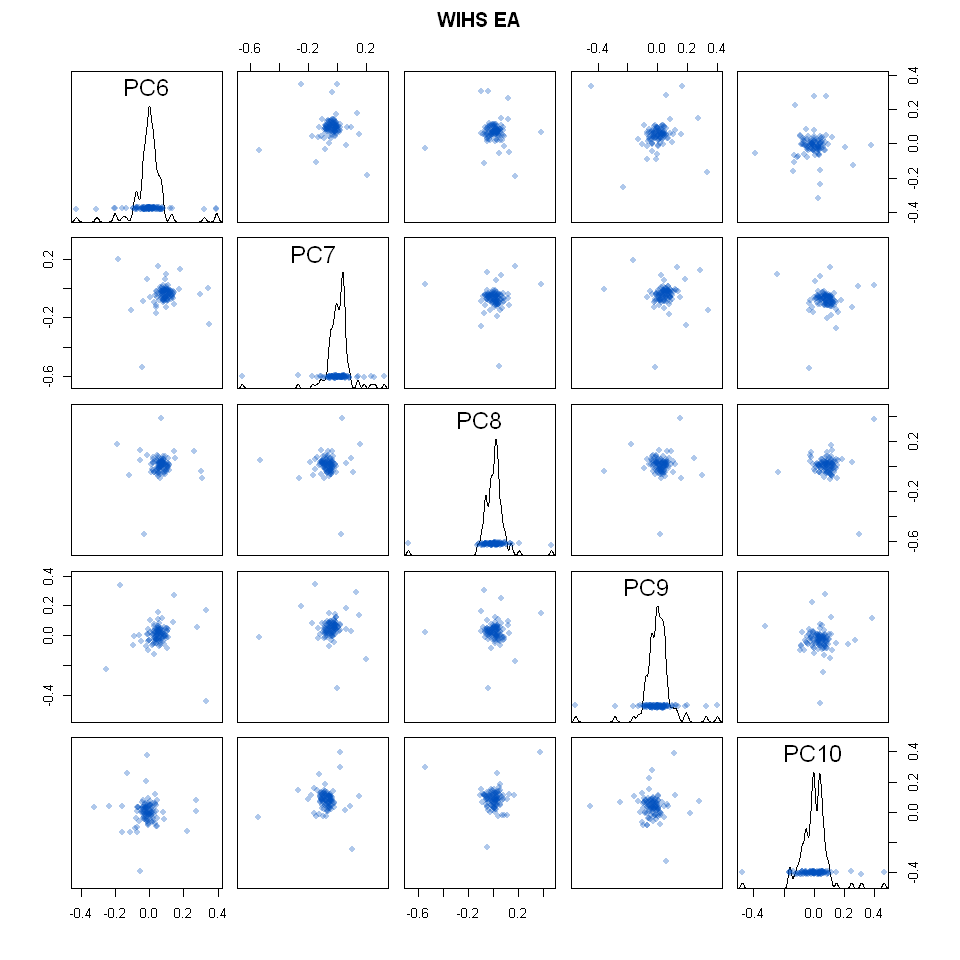

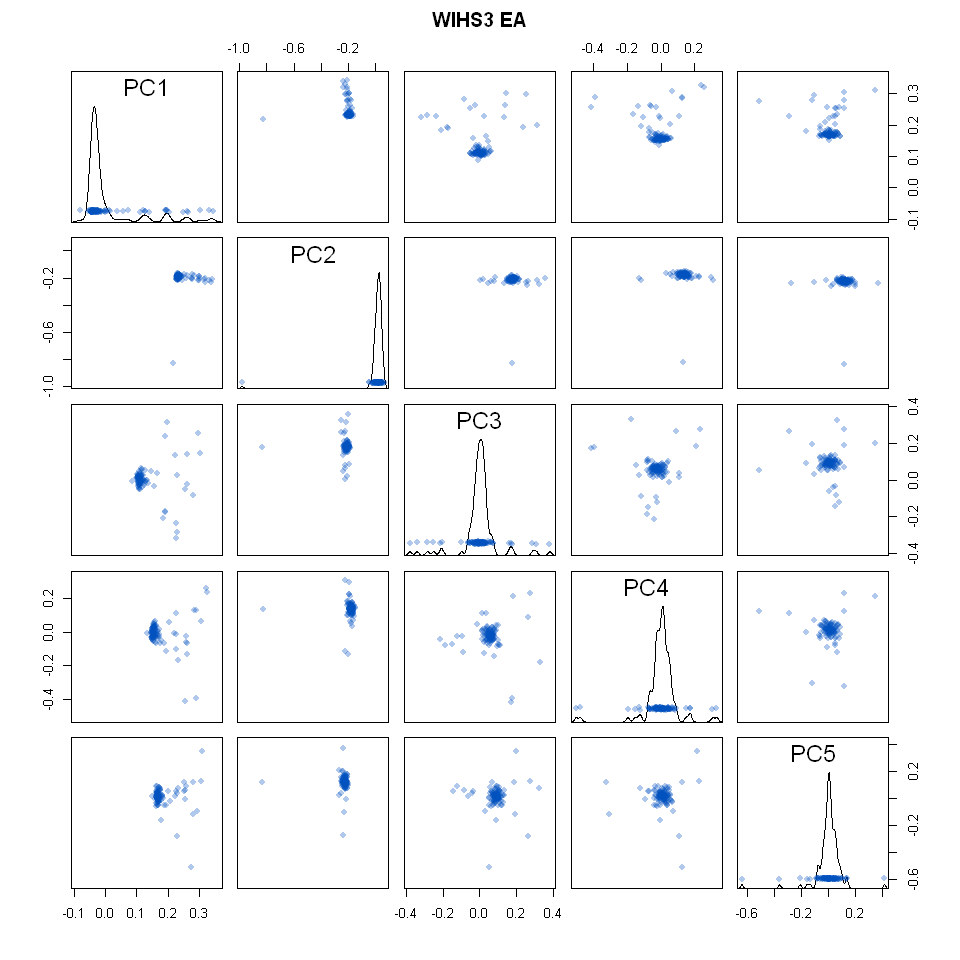

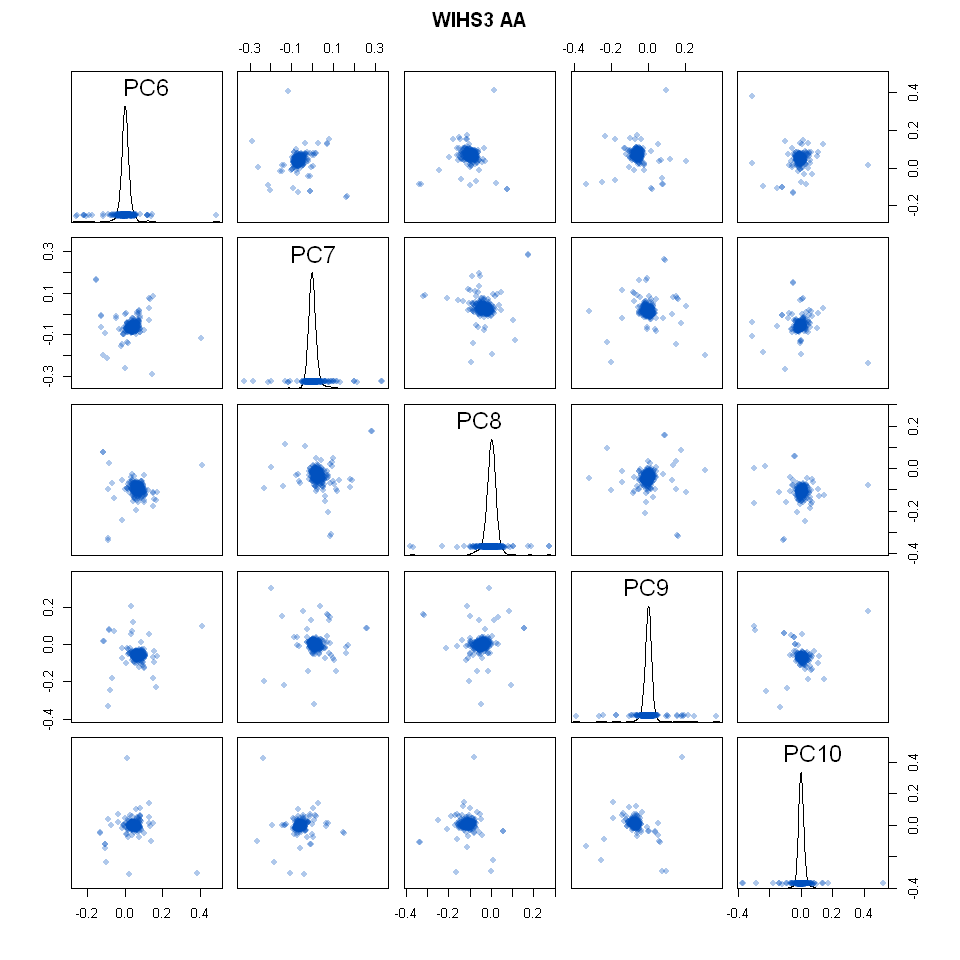

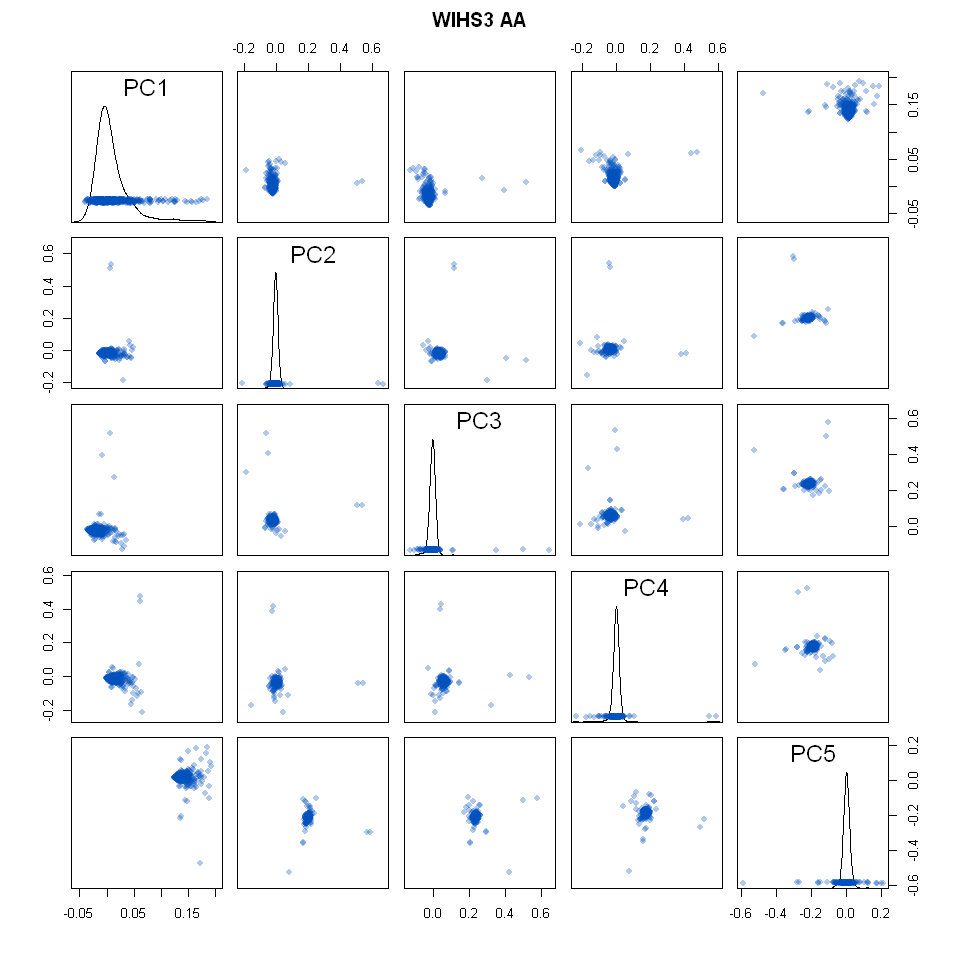

In [23]:
### View PCs ###
## R console ##
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

## EA ##
#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="WIHS EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="WIHS3 EA", cex.main=1)

## AA ##
#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="WIHS3 AA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="WIHS3 AA", cex.main=1)

### PC Selection

In [27]:
### PC Selection ###
## R functions, DO NOT ALTER THIS CODE ##
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[2]
    
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    
    } # end function

regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

#### AA

fid  iid    patid matid sex hiv
1 3432 204477 NA    NA    2   0  
2 3432 209890 NA    NA    2   1  
3 3433 210459 NA    NA    2   1  
4 3434 218207 NA    NA    2   0  
5 3434 219343 NA    NA    2   0  
6 3435 204110 NA    NA    2   0

MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AFR group ================
Top PCs:  PC3 PC8 PC2 
PVE:      86.86

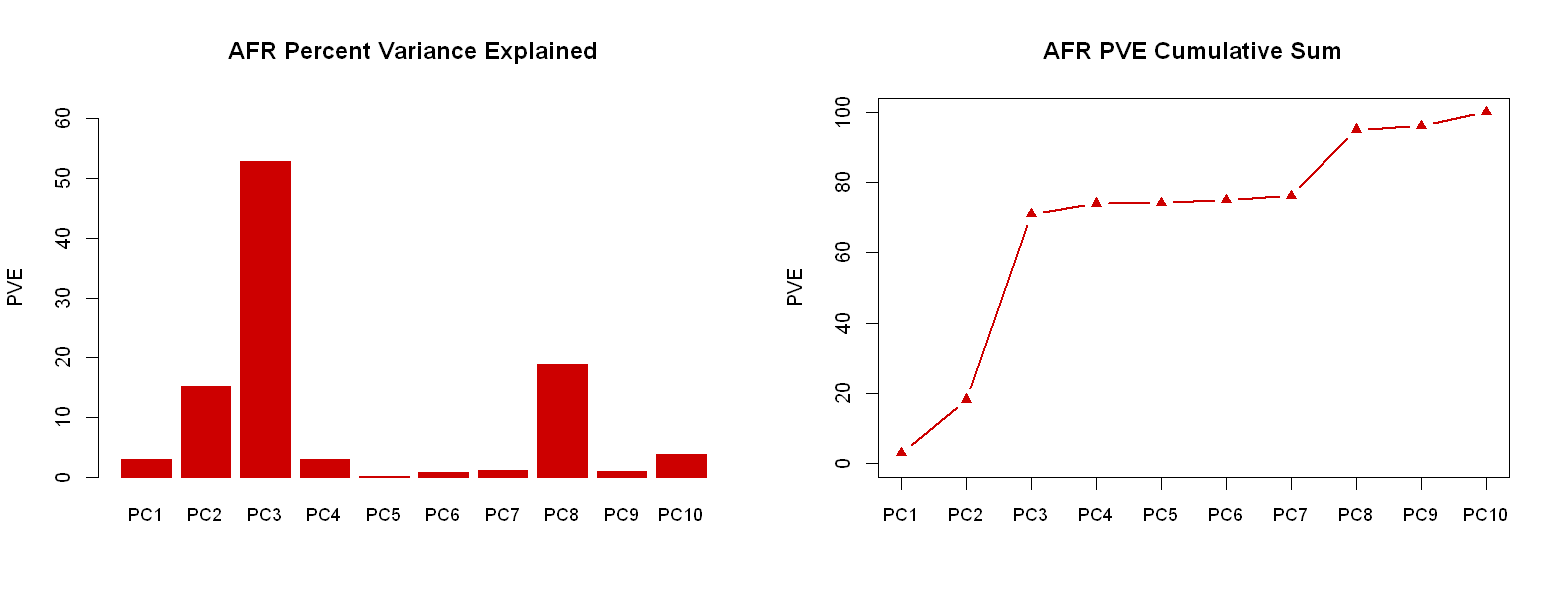

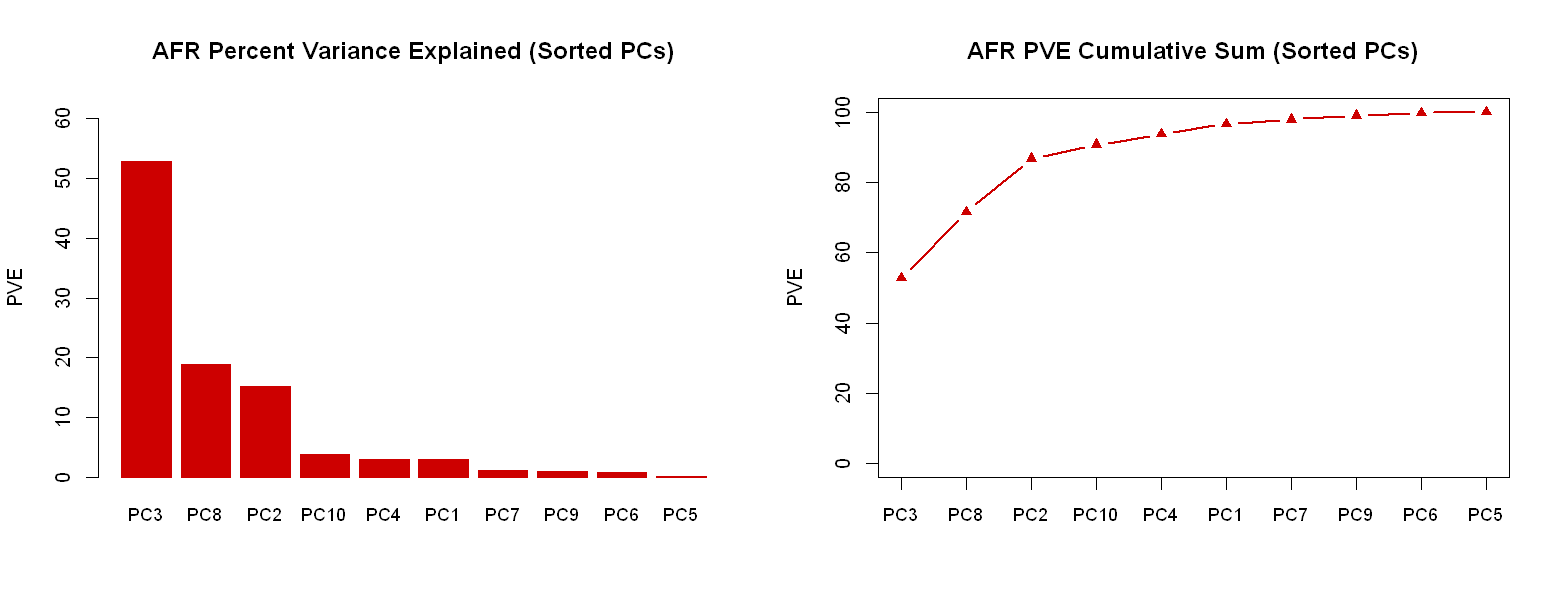

In [38]:
study <- "WIHS3" # all caps
ancestry <- "AFR" # EUR or AFR

## variable information from phenotype file ($study_$an_phenotype_table.txt)
phenotype <- "hiv" 
sex_var <-  "sex" 
covs <- c(sex_var, "age")

phen_file <- "wihs3_aa_phenotype_table.txt"
pca_file <- "aa_ld_pruned_top10_eigenvecs.txt"

model_type <- "logistic" # continuous or logistic (if log then must be coded 0 or 1)
####################################################################################################
####################################################################################################

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

#### EA

fid  iid    patid matid sex hiv
1 3466 205092 NA    NA    2   1  
2 3469 217359 NA    NA    2   0  
3 3472 204989 NA    NA    2   0  
4 3474 205582 NA    NA    2   1  
5 3476 210788 NA    NA    2   1  
6 3488 204676 NA    NA    2   1

MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC9 PC7 PC2 PC10 
PVE:      77.2

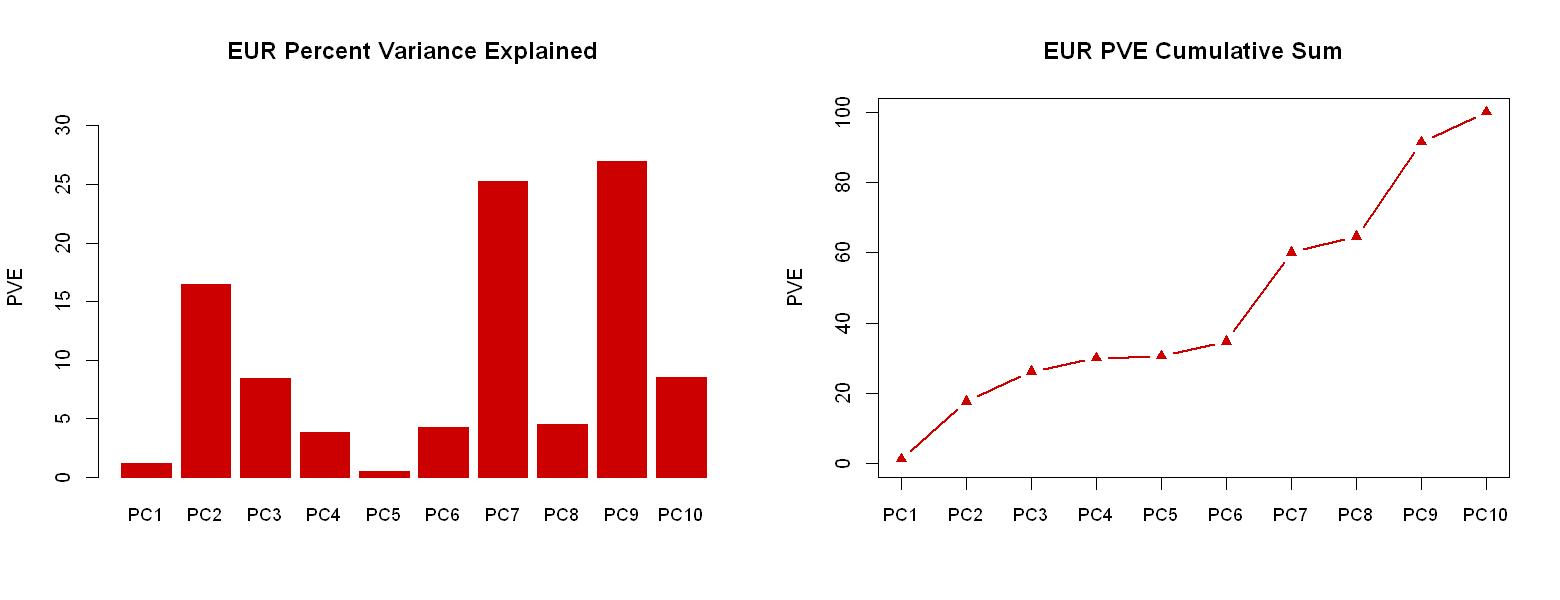

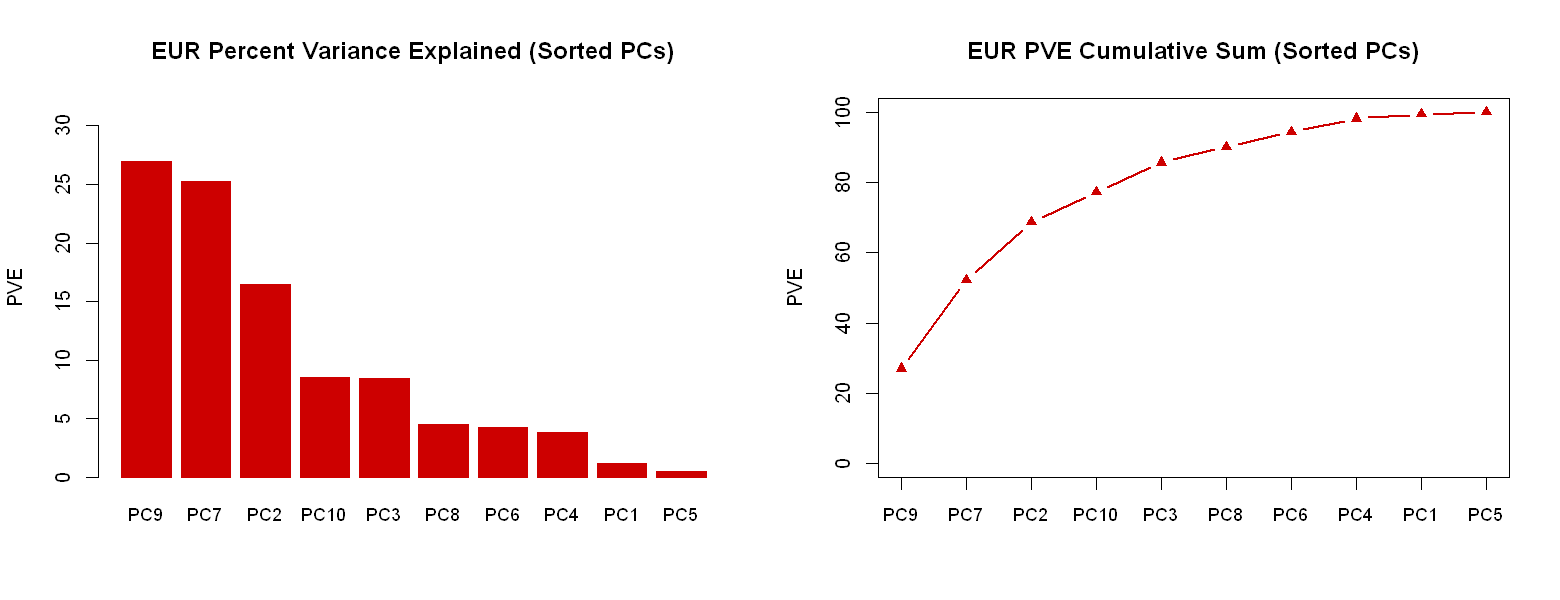

In [39]:
study <- "WIHS3" # all caps
ancestry <- "EUR" # EUR or AFR

## variable information from phenotype file ($study_$an_phenotype_table.txt)
phenotype <- "hiv" 
sex_var <-  "sex" 
covs <- c(sex_var, "age")

phen_file <- "wihs3_ea_phenotype_table.txt"
pca_file <- "ea_ld_pruned_top10_eigenvecs.txt"

model_type <- "logistic" # continuous or logistic
####################################################################################################
####################################################################################################

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
## Bash ##
study=WIHS3

## AA
#awk '{OFS="_"} { print $2,$2 } ' ${study}_AFR_phen.ped > new_id
#awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
#    new_id ${study}_AFR_phen.ped > ${study}_NGCW1_AFR_phen.ped
#awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
#    new_id ${study}_AFR_cov.ped > ${study}_NGCW1_AFR_cov.ped
#
#
## EA
#awk '{OFS="_"} { print $2,$2 } ' ${study}_EUR_phen.ped > new_id
#awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
#    new_id ${study}_EUR_phen.ped > ${study}_NGCW1_EUR_phen.ped
#awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
#    new_id ${study}_EUR_cov.ped > ${study}_NGCW1_EUR_cov.ped
#
#scp -i ~/.ssh/gwas_rsa *NGCW1* ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing

### Create ProbABEL phenotype file

In [53]:
### Convert your phenotype PED files (as required for rvtests) to the ProbABEL format ###
## R function, DO NOT ALTER THIS CODE ##
probabel_phenotype <- function(cov_file, pheno_file, study, pop, pcs, other_covs, pheno){
    
    pc_paste <- paste(pcs, collapse="+")
    othercov_paste <- paste(other_covs, collapse="_")
    out_name <- paste(study, pop, pheno, othercov_paste, pc_paste, sep="_")
    out_name <- paste0(out_name, ".txt")

    all_covs <- c(other_covs, pcs)

    # read in data files
    my_cov <- read.table(cov_file, header=T)
    my_pheno <- read.table(pheno_file, header=T)

    num.subjects <- length(my_cov[,1])

    # create new phenotype file (dataframe)
    num_cols = 2 + length(other_covs) # iid + pheno + covs
    covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
    names(covar.data) <- c("iid", pheno, other_covs)
    covar.data[1] <- paste(my_pheno$fid, my_pheno$iid, sep = "_")
    covar.data[2] <- my_pheno[, pheno]

    for (cov in all_covs){
        covar.data[, cov] <- my_cov[,cov]
    }

    write.table(x = covar.data, file = out_name, quote = F, row.names = F)
    write.table(x = covar.data[,1], file = paste0("phenotype_ids_", pop), 
                quote = F, row.names = F, col.names=F)
}

In [54]:
### AA
cov_file   <- "WIHS3_AFR_cov.ped"  # name of the input file
pheno_file <- "WIHS3_AFR_phen.ped" # name of the input file
study <- "wihs3" # lowercase
pop <- "aa"
pcs = c("PC3", "PC8", "PC2")
other_covs <- c("age", "sex") # field names in header of cov file
pheno <- "hiv" # field names in header of phen file
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)

### EA
cov_file   <- "WIHS3_EUR_cov.ped"  # name of the input file
pheno_file <- "WIHS3_EUR_phen.ped" # name of the input file
study <- "wihs3" # lowercase
pop <- "ea"
pcs = c("PC9", "PC7", "PC2", "PC10")
other_covs <- c("age", "sex") # field names in header of cov file
pheno <- "hiv" # field names in header of phen file
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)